In [1]:
%pip install catboost

In [2]:
# 01_imports_week6.py
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import early_stopping
from scipy.stats import ks_2samp
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
sns.set(style="whitegrid")
%matplotlib inline
import plotly.express as px
import seaborn as sns
from sklearn.inspection import permutation_importance
from datetime import datetime, timedelta
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score

In [3]:
# 02_load_week6.py
df = pd.read_parquet("/content/flights_cleaned_week2.parquet")
print("Shape:", df.shape)


Shape: (100000, 51)


In [4]:
# 03_targets_week6.py
df['delay_class'] = (df['ARR_DELAY'] > 15).astype(int)
df['delay_reg'] = df['ARR_DELAY'].fillna(0)


In [5]:
# 04_encode_week6.py
# Encode categorical features and split data
features = [c for c in ['DEP_DELAY','DISTANCE','hour','day_of_week','month','OP_CARRIER','ORIGIN','DEST'] if c in df.columns]
X = pd.get_dummies(df[features], drop_first=True)
y_class = df['delay_class']
y_reg = df['delay_reg']
print("Encoded features:", X.shape)

Encoded features: (100000, 751)


In [6]:
# 05_time_split.py
# Split data into training and testing sets based on time
df = df.sort_values('FL_DATE')
split = int(len(df)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train_c, y_test_c = y_class.iloc[:split], y_class.iloc[split:]
y_train_r, y_test_r = y_reg.iloc[:split], y_reg.iloc[split:]
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (80000, 751) Test size: (20000, 751)


GB Classifier AUC: 0.9238653023619506


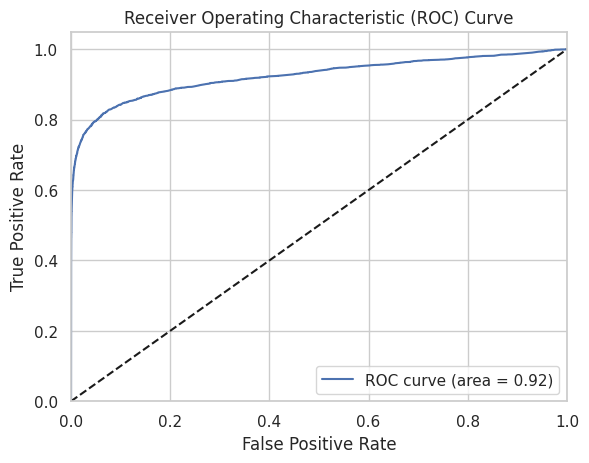

In [7]:
# 06_gb_classifier.py
# Train Gradient Boosting Classifier

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

gb_c = GradientBoostingClassifier()
gb_c.fit(X_train_imputed, y_train_c)
print("GB Classifier AUC:", roc_auc_score(y_test_c, gb_c.predict_proba(X_test_imputed)[:,1]))

# Add ROC curve plot
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_c, gb_c.predict_proba(X_test_imputed)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test_c, gb_c.predict_proba(X_test_imputed)[:,1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

GB Regressor R²: 0.9385802478702857


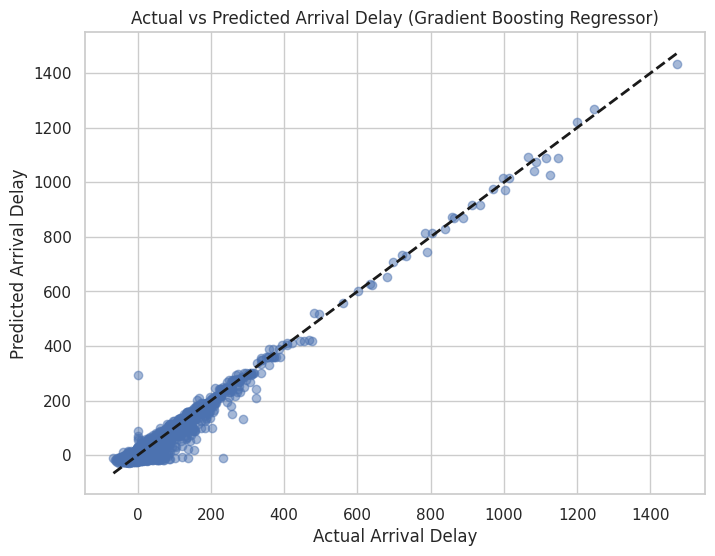

In [8]:
# 07_gb_regressor.py
# Train Gradient Boosting Regressor

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

gb_r = GradientBoostingRegressor()
gb_r.fit(X_train_imputed, y_train_r)
print("GB Regressor R²:", gb_r.score(X_test_imputed, y_test_r))

# Add scatter plot of actual vs predicted values
y_pred_r = gb_r.predict(X_test_imputed)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_r, y_pred_r, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'k--', lw=2)
plt.xlabel('Actual Arrival Delay')
plt.ylabel('Predicted Arrival Delay')
plt.title('Actual vs Predicted Arrival Delay (Gradient Boosting Regressor)')
plt.show()

XGB Classifier AUC: 0.9254358672521267


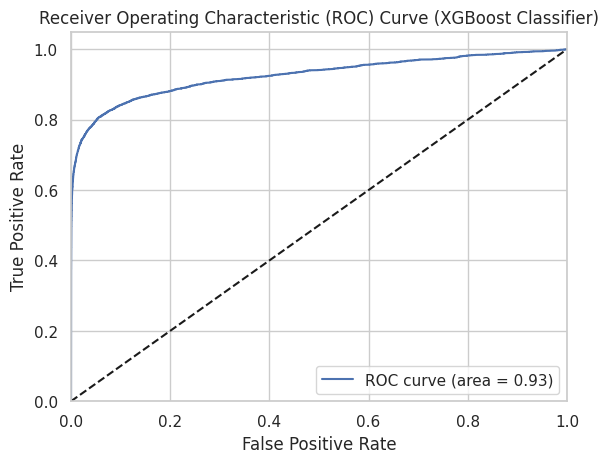

In [9]:
# 08_xgb_classifier.py
xgb_c = XGBClassifier(eval_metric='logloss', random_state=1)
xgb_c.fit(X_train, y_train_c)
print("XGB Classifier AUC:", roc_auc_score(y_test_c, xgb_c.predict_proba(X_test)[:,1]))

# Add ROC curve plot
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_c, xgb_c.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test_c, xgb_c.predict_proba(X_test)[:,1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (XGBoost Classifier)')
plt.legend(loc="lower right")
plt.show()

[LightGBM] [Info] Number of positive: 14199, number of negative: 65801
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 401
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.177487 -> initscore=-1.533463
[LightGBM] [Info] Start training from score -1.533463
LightGBM Classifier AUC: 0.9256151362028359


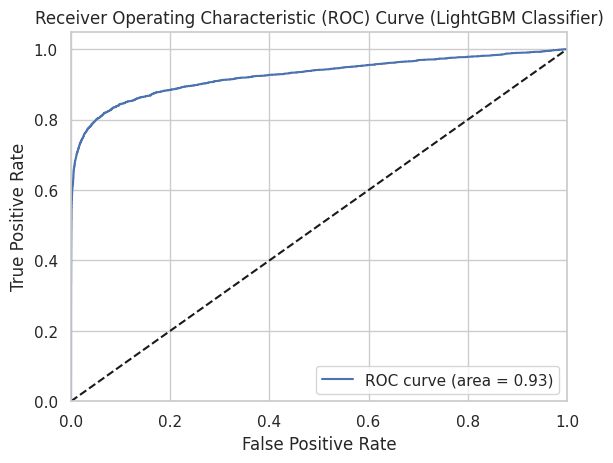

In [10]:
# 09_lgbm_classifier.py
lgbm_c = LGBMClassifier(random_state=1)
lgbm_c.fit(X_train, y_train_c)
print("LightGBM Classifier AUC:", roc_auc_score(y_test_c, lgbm_c.predict_proba(X_test)[:,1]))

# Add ROC curve plot
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_c, lgbm_c.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test_c, lgbm_c.predict_proba(X_test)[:,1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (LightGBM Classifier)')
plt.legend(loc="lower right")
plt.show()

CatBoost Classifier AUC: 0.9256090833537289


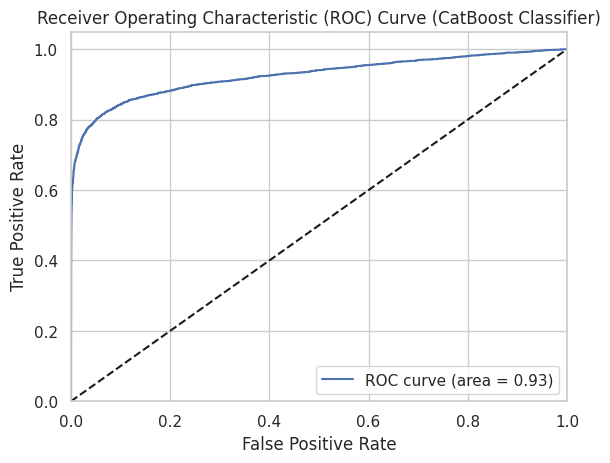

In [11]:
# 10_catboost_classifier.py
cat_c = CatBoostClassifier(verbose=0, random_state=1)
cat_c.fit(X_train, y_train_c)
print("CatBoost Classifier AUC:", roc_auc_score(y_test_c, cat_c.predict_proba(X_test)[:,1]))

# Add ROC curve plot
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_c, cat_c.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test_c, cat_c.predict_proba(X_test)[:,1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (CatBoost Classifier)')
plt.legend(loc="lower right")
plt.show()

Best XGB params: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.01}


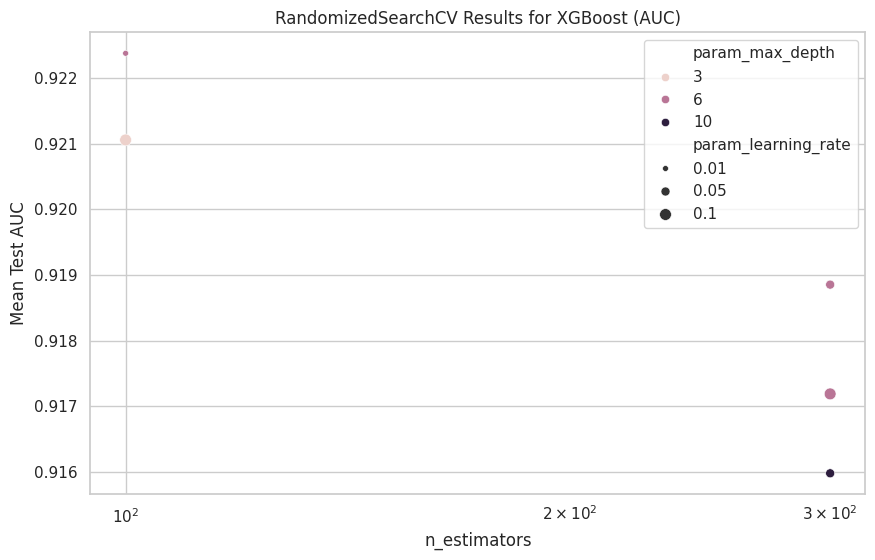

In [12]:
# 11_xgb_random_tune.py
params = {'n_estimators':[100,200,300], 'max_depth':[3,6,10], 'learning_rate':[0.01,0.05,0.1]}
rs_xgb = RandomizedSearchCV(XGBClassifier(eval_metric='logloss'), params, cv=3, scoring='roc_auc', n_iter=5, n_jobs=-1, random_state=1)
rs_xgb.fit(X_train, y_train_c)
print("Best XGB params:", rs_xgb.best_params_)

# Add visualization of results
results = pd.DataFrame(rs_xgb.cv_results_)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x='param_n_estimators', y='mean_test_score', hue='param_max_depth', size='param_learning_rate')
plt.title('RandomizedSearchCV Results for XGBoost (AUC)')
plt.xlabel('n_estimators')
plt.ylabel('Mean Test AUC')
plt.xscale('log')
plt.show()

[LightGBM] [Info] Number of positive: 14199, number of negative: 65801
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 401
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.177487 -> initscore=-1.533463
[LightGBM] [Info] Start training from score -1.533463
Best iteration: 77


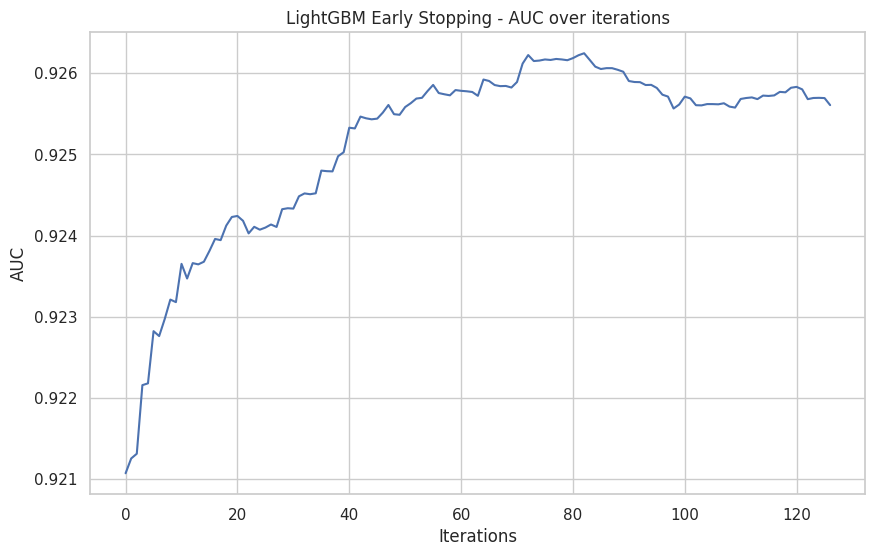

In [13]:
# 12_lgbm_earlystop.py
lgbm_c2 = LGBMClassifier(n_estimators=1000, random_state=1)
lgbm_c2.fit(X_train, y_train_c,
            eval_set=[(X_test,y_test_c)],
            eval_metric='auc',
            callbacks=[early_stopping(stopping_rounds=50, verbose=False)])
print("Best iteration:", lgbm_c2.best_iteration_)

# Add visualization of evaluation results
eval_results = lgbm_c2.evals_result_['valid_0']['auc']
plt.figure(figsize=(10, 6))
plt.plot(eval_results)
plt.title('LightGBM Early Stopping - AUC over iterations')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.show()

CatBoost tuned AUC: 0.9252131448229524


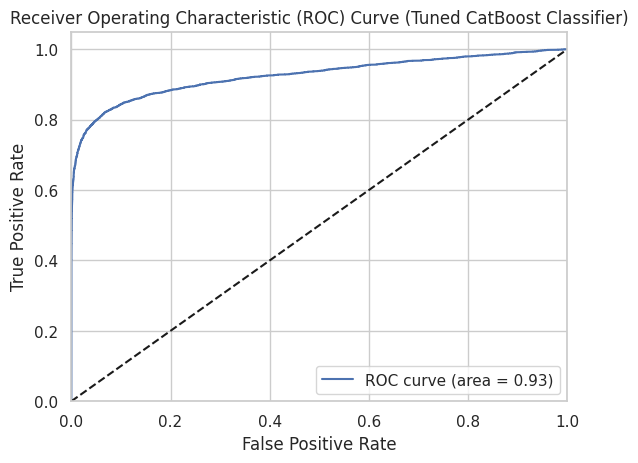

In [14]:
# 13_catboost_tuned.py
cat_c2 = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.05, verbose=0, random_state=1)
cat_c2.fit(X_train, y_train_c)
print("CatBoost tuned AUC:", roc_auc_score(y_test_c, cat_c2.predict_proba(X_test)[:,1]))

# Add ROC curve plot
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_c, cat_c2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test_c, cat_c2.predict_proba(X_test)[:,1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Tuned CatBoost Classifier)')
plt.legend(loc="lower right")
plt.show()

AUC early test: 0.921066243007104 AUC late test: 0.9295207242109327


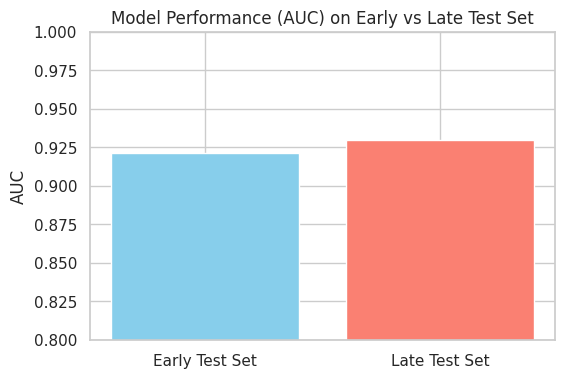

In [15]:
# 14_drift_simulation.py
mid = int(len(X_test)/2)
auc_early = roc_auc_score(y_test_c.iloc[:mid], cat_c2.predict_proba(X_test.iloc[:mid])[:,1])
auc_late = roc_auc_score(y_test_c.iloc[mid:], cat_c2.predict_proba(X_test.iloc[mid:])[:,1])
print("AUC early test:", auc_early, "AUC late test:", auc_late)

# Add bar plot of AUC early vs late
plt.figure(figsize=(6, 4))
plt.bar(['Early Test Set', 'Late Test Set'], [auc_early, auc_late], color=['skyblue', 'salmon'])
plt.ylabel('AUC')
plt.title('Model Performance (AUC) on Early vs Late Test Set')
plt.ylim([0.8, 1.0]) # Assuming AUC is expected to be in this range
plt.show()

PSI (DEP_DELAY train vs test): 0.0


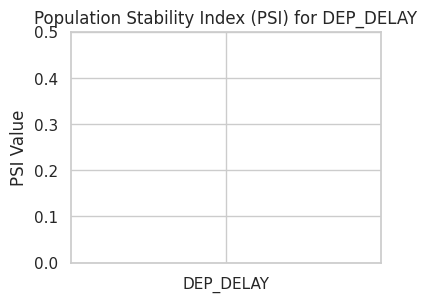

In [16]:
# 15_psi_function.py
def psi(expected, actual, buckets=10):
    def scale(series):
        return pd.qcut(series.rank(method='first'), buckets, labels=False, duplicates='drop')
    e_perc = scale(expected).value_counts(normalize=True, sort=False)
    a_perc = scale(actual).value_counts(normalize=True, sort=False)
    psi_val = np.sum((e_perc - a_perc) * np.log((e_perc + 1e-6)/(a_perc + 1e-6)))
    return psi_val

psi_val = psi(X_train['DEP_DELAY'], X_test['DEP_DELAY'])
print("PSI (DEP_DELAY train vs test):", psi_val)

# Add bar plot for PSI value
plt.figure(figsize=(4, 3))
plt.bar(['DEP_DELAY'], [psi_val], color='teal')
plt.ylabel('PSI Value')
plt.title('Population Stability Index (PSI) for DEP_DELAY')
plt.ylim([0, max(psi_val + 0.1, 0.5)]) # Adjust ylim based on PSI value
plt.show()

KS test DEP_DELAY train vs test: stat=0.045, p=0.000


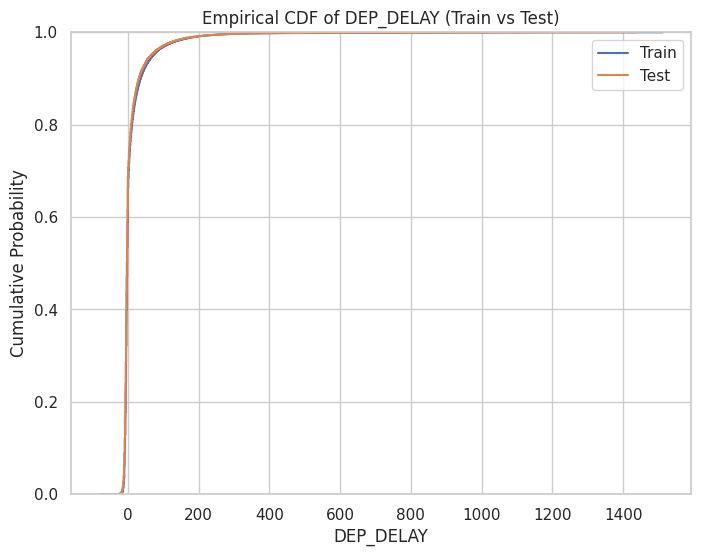

In [17]:
# 16_ks_test_drift.py
stat, pval = ks_2samp(X_train['DEP_DELAY'], X_test['DEP_DELAY'])
print("KS test DEP_DELAY train vs test: stat=%.3f, p=%.3f"%(stat,pval))

# Add visualization of CDFs
plt.figure(figsize=(8, 6))
sns.ecdfplot(data=X_train, x='DEP_DELAY', label='Train')
sns.ecdfplot(data=X_test, x='DEP_DELAY', label='Test')
plt.title('Empirical CDF of DEP_DELAY (Train vs Test)')
plt.xlabel('DEP_DELAY')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

Rolling accuracy over windows: [0.9382, 0.937, 0.949, 0.9462]


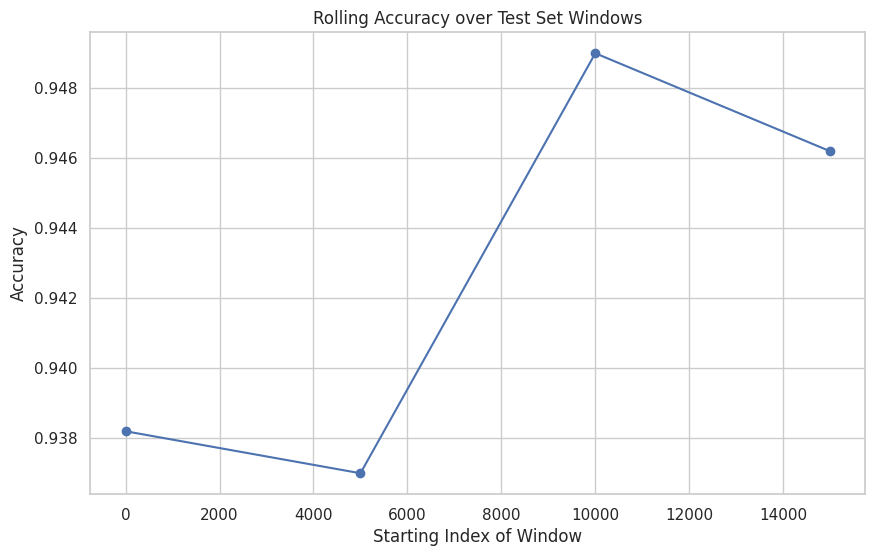

In [18]:
# 17_rolling_accuracy.py
win_size = 5000
accs = []
for i in range(0,len(X_test),win_size):
    acc = accuracy_score(y_test_c.iloc[i:i+win_size], cat_c2.predict(X_test.iloc[i:i+win_size]))
    accs.append(acc)
print("Rolling accuracy over windows:", accs)

# Add plot for rolling accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(X_test), win_size), accs, marker='o')
plt.title('Rolling Accuracy over Test Set Windows')
plt.xlabel('Starting Index of Window')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [19]:
# 18_log_metrics.py
import json
import os

# Create the directory if it doesn't exist
os.makedirs("/mnt/data/", exist_ok=True)

metrics = {
    "gb_auc": float(roc_auc_score(y_test_c, gb_c.predict_proba(X_test_imputed)[:,1])),
    "xgb_auc": float(roc_auc_score(y_test_c, xgb_c.predict_proba(X_test)[:,1])),
    "lgbm_auc": float(roc_auc_score(y_test_c, lgbm_c.predict_proba(X_test)[:,1])),
    "cat_auc": float(roc_auc_score(y_test_c, cat_c.predict_proba(X_test)[:,1]))
}
with open("/mnt/data/week6_model_metrics.json","w") as f:
    json.dump(metrics,f)
print("Saved metrics to JSON.")

Saved metrics to JSON.


In [20]:
# 19_save_catboost.py
import joblib
joblib.dump(cat_c2, "/mnt/data/best_catboost_week6.pkl")
print("Saved CatBoost model.")


Saved CatBoost model.


Brier score (CatBoost): 0.04700958772110896


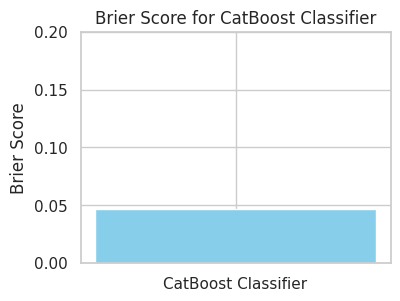

In [21]:
# 20_brier_score.py
prob = cat_c2.predict_proba(X_test)[:,1]
brier = brier_score_loss(y_test_c, prob)
print("Brier score (CatBoost):", brier)

# Add a bar plot for the Brier score
plt.figure(figsize=(4, 3))
plt.bar(['CatBoost Classifier'], [brier], color='skyblue')
plt.ylabel('Brier Score')
plt.title('Brier Score for CatBoost Classifier')
plt.ylim([0, max(brier + 0.05, 0.2)]) # Adjust ylim based on expected Brier score range
plt.show()

In [22]:
# 21_multi_feature_psi.py
def psi_series(expected, actual, buckets=10):
    expected_bins = pd.qcut(expected.rank(method='first'), buckets, labels=False, duplicates='drop')
    actual_bins = pd.qcut(actual.rank(method='first'), buckets, labels=False, duplicates='drop')
    e_perc = expected_bins.value_counts(normalize=True).sort_index()
    a_perc = actual_bins.value_counts(normalize=True).sort_index()
    psi_val = np.sum((e_perc - a_perc) * np.log((e_perc+1e-6)/(a_perc+1e-6)))
    return psi_val

features_to_monitor = ['DEP_DELAY','DISTANCE','hour']
psi_results = {f: psi_series(X_train[f], X_test[f]) for f in features_to_monitor if f in X_train.columns}
print("PSI results:", psi_results)


PSI results: {'DEP_DELAY': np.float64(0.0), 'DISTANCE': np.float64(0.0), 'hour': np.float64(0.0)}


In [23]:
# 22_simple_alerting.py
alerts = []
for f, v in psi_results.items():
    if v > 0.25:
        alerts.append(f"ALERT: PSI for {f} = {v:.3f} (>0.25)")
if alerts:
    for a in alerts: print(a)
else:
    print("No PSI alerts.")


No PSI alerts.


In [24]:
# 23_monitoring_df_creation.py
window = 5000
rows = []
for i in range(0, len(X_test), window):
    idx = slice(i, i+window)
    preds = cat_c2.predict(X_test.iloc[idx])
    acc = accuracy_score(y_test_c.iloc[idx], preds)
    rows.append({'start': i, 'end': i+window-1, 'accuracy': acc})
monitor_df = pd.DataFrame(rows)
print(monitor_df.head())


   start    end  accuracy
0      0   4999    0.9382
1   5000   9999    0.9370
2  10000  14999    0.9490
3  15000  19999    0.9462


In [25]:
# 24_retrain_trigger.py
threshold = 0.72
if monitor_df['accuracy'].min() < threshold:
    print("Triggering retrain: min accuracy", monitor_df['accuracy'].min())
    # Place retrain code here (or call training pipeline)
else:
    print("No retrain required. Accuracy OK.")


No retrain required. Accuracy OK.


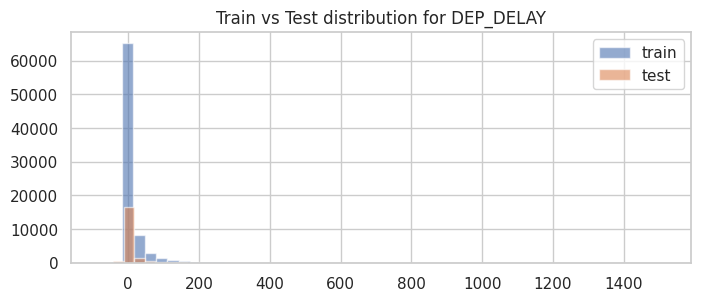

In [26]:
# 25_feature_drift_plot.py
f = 'DEP_DELAY'
if f in X_train.columns:
    plt.figure(figsize=(8,3))
    plt.hist(X_train[f].dropna(), bins=50, alpha=0.6, label='train')
    plt.hist(X_test[f].dropna(), bins=50, alpha=0.6, label='test')
    plt.title(f'Train vs Test distribution for {f}')
    plt.legend()
    plt.show()
else:
    print(f"{f} not in features")


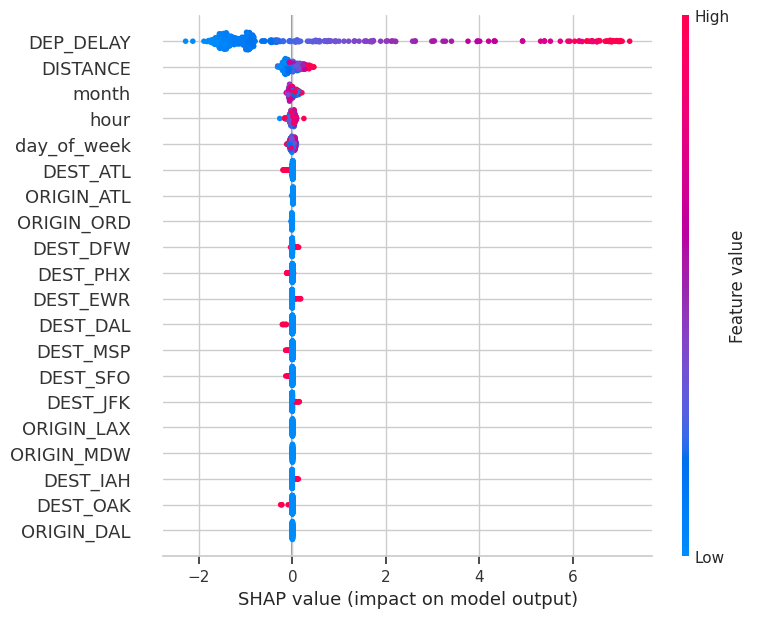

In [27]:
# 26_shap_week6.py
try:
    import shap
    explainer = shap.TreeExplainer(cat_c2)
    sample = X_test.sample(n=min(500, len(X_test)), random_state=1)
    shap_vals = explainer.shap_values(sample)
    shap.summary_plot(shap_vals, sample, show=False)
    plt.gcf().set_size_inches(8,6);
    plt.show()
except Exception as e:
    print("SHAP failed or not installed:", e)


In [28]:
# 27_batch_evaluation_fn.py
def evaluate_batch(X_batch, y_batch, model=cat_c2):
    prob = model.predict_proba(X_batch)[:,1]
    return {
        'accuracy': accuracy_score(y_batch, (prob>=0.5).astype(int)),
        'roc_auc': roc_auc_score(y_batch, prob),
        'brier': brier_score_loss(y_batch, prob)
    }


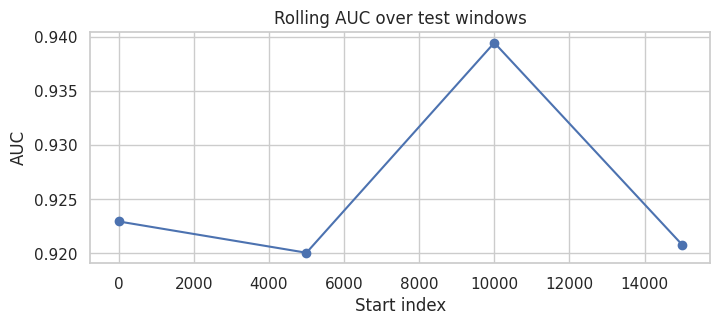

In [29]:
# 28_rolling_auc_plot.py
win = 5000
aucs = []
idxs = []
for i in range(0, len(X_test), win):
    prob = cat_c2.predict_proba(X_test.iloc[i:i+win])[:,1]
    aucs.append(roc_auc_score(y_test_c.iloc[i:i+win], prob))
    idxs.append(i)
plt.figure(figsize=(8,3))
plt.plot(idxs, aucs, marker='o')
plt.title('Rolling AUC over test windows')
plt.xlabel('Start index')
plt.ylabel('AUC')
plt.show()


Correlation differences (test - train):
            DEP_DELAY  DISTANCE      hour
DEP_DELAY   0.000000 -0.015190 -0.025336
DISTANCE   -0.015190  0.000000  0.018228
hour       -0.025336  0.018228  0.000000


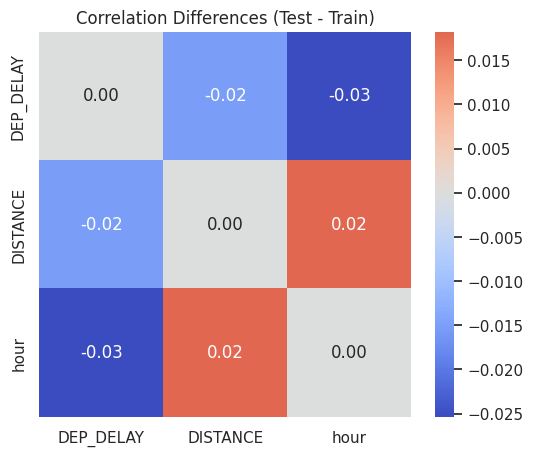

In [30]:
# 29_corr_change.py
corr_train = X_train[features_to_monitor].corr()
corr_test = X_test[features_to_monitor].corr()
corr_diff = corr_test - corr_train
print("Correlation differences (test - train):\n", corr_diff)

# Add heatmap of correlation differences
plt.figure(figsize=(6, 5))
sns.heatmap(corr_diff, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Differences (Test - Train)')
plt.show()

In [31]:
# 30_model_rollback.py
def rollback_model(current_model_path, previous_model_path):
    import shutil
    shutil.copy(previous_model_path, current_model_path)
    print(f"Rolled back model: {previous_model_path} -> {current_model_path}")



In [32]:
# 31_drift_score_aggregator.py
def drift_score(X_train, X_test, y_train, y_test, model):
    psi_sum = sum(psi_results.values()) if psi_results else 0
    ks_stats = {f: ks_2samp(X_train[f], X_test[f]).statistic for f in features_to_monitor if f in X_train.columns}
    auc_change = roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) - roc_auc_score(y_train, model.predict_proba(X_train)[:,1]) if hasattr(model, 'predict_proba') else 0
    return {'psi_sum': psi_sum, 'max_ks': max(ks_stats.values()) if ks_stats else 0, 'auc_change': auc_change}

drift = drift_score(X_train, X_test, y_train_c, y_test_c, cat_c2)
print("Drift summary:", drift)


Drift summary: {'psi_sum': np.float64(0.0), 'max_ks': np.float64(0.04477500000000001), 'auc_change': np.float64(-0.012461523881379777)}


In [33]:
# 32_retrain_schedule
last_trained = pd.Timestamp.now() - pd.Timedelta(days=30)
if pd.Timestamp.now() - last_trained > pd.Timedelta(days=28) or drift['psi_sum'] > 0.5:
    print("Triggering scheduled retrain.")
else:
    print("No scheduled retrain required.")


Triggering scheduled retrain.


In [34]:
# 33_calibration_table.py
prob = cat_c2.predict_proba(X_test)[:,1]
frac_pos, mean_pred = calibration_curve(y_test_c, prob, n_bins=10)
cal_table = pd.DataFrame({'mean_pred': mean_pred, 'frac_pos': frac_pos})
print("Calibration table:\n", cal_table)


Calibration table:
    mean_pred  frac_pos
0   0.034920  0.031024
1   0.140357  0.140787
2   0.245454  0.203863
3   0.345118  0.302632
4   0.445327  0.425703
5   0.550905  0.545455
6   0.646825  0.600000
7   0.751335  0.769697
8   0.853615  0.874396
9   0.979160  0.987151


In [35]:
# 34_synthetic_inference_test.py
sample_row = X_test.iloc[0:1]
print("Sample pred prob:", cat_c2.predict_proba(sample_row)[:,1])


Sample pred prob: [0.02961393]


In [36]:
# 35_feature_importance_stability.py
# compute importance on early and late windows and compare
early_imp = permutation_importance(cat_c2, X_test.iloc[:1000], y_test_c.iloc[:1000], n_repeats=5, random_state=1)
late_imp = permutation_importance(cat_c2, X_test.iloc[-1000:], y_test_c.iloc[-1000:], n_repeats=5, random_state=1)
early_top = pd.Series(early_imp.importances_mean, index=X_test.columns).nlargest(10)
late_top = pd.Series(late_imp.importances_mean, index=X_test.columns).nlargest(10)
print("Early top features:\n", early_top)
print("Late top features:\n", late_top)

Early top features:
 DEP_DELAY      0.1848
month          0.0008
DEST_ATL       0.0008
day_of_week    0.0006
DEST_BWI       0.0002
DEST_DAL       0.0002
ORIGIN_ABI     0.0000
ORIGIN_ABQ     0.0000
ORIGIN_ABR     0.0000
ORIGIN_ABY     0.0000
dtype: float64
Late top features:
 DEP_DELAY      0.1652
DISTANCE       0.0000
hour           0.0000
day_of_week    0.0000
month          0.0000
ORIGIN_ABI     0.0000
ORIGIN_ABQ     0.0000
ORIGIN_ABR     0.0000
ORIGIN_ABY     0.0000
ORIGIN_ACK     0.0000
dtype: float64


In [37]:
# 36_api_predict_fn.py
def api_predict(df_row, model=cat_c2):
    # df_row: single-row DataFrame with same columns as X_train before dummies
    # simple flow: dummify then select columns
    row_enc = pd.get_dummies(df_row, drop_first=True)
    # align with training columns
    for c in X_train.columns:
        if c not in row_enc.columns:
            row_enc[c] = 0
    row_enc = row_enc[X_train.columns]
    return model.predict_proba(row_enc)[:,1][0]

In [38]:
# 37_cost_sensitive_threshold.py
# assume cost_fp and cost_fn are known
cost_fp = 1.0
cost_fn = 5.0
probs = cat_c2.predict_proba(X_test)[:,1]
thresholds = np.linspace(0.01,0.99,99)
costs = []
for t in thresholds:
    preds = (probs>=t).astype(int)
    fp = ((preds==1) & (y_test_c==0)).sum()
    fn = ((preds==0) & (y_test_c==1)).sum()
    total_cost = fp*cost_fp + fn*cost_fn
    costs.append(total_cost)
best_t = thresholds[np.argmin(costs)]
print("Best threshold to minimize cost:", best_t)


Best threshold to minimize cost: 0.17


In [39]:
# 38_Ensure OP_CARRIER exists, create CANCELLED flag if not present but can infer
if 'OP_CARRIER' not in df.columns:
    found_carrier_col = None
    for col in df.columns:
        if 'CARRIER' in col.upper() or 'AIRLINE' in col.upper():
            found_carrier_col = col
            break
    if found_carrier_col:
        df['OP_CARRIER'] = df[found_carrier_col]
        print(f"Found and used column '{found_carrier_col}' as 'OP_CARRIER'.")
    else:
        print("Warning: Neither 'OP_CARRIER' nor a similar column ('CARRIER', 'AIRLINE') found.")


if 'CANCELLED' not in df.columns:
    # If cancellation not present, infer from missing times or specific column
    df['CANCELLED'] = df.get('CANCELLED', 0)
df['CANCELLED'] = df['CANCELLED'].fillna(0).astype(int)

# Now it should be safe to access OP_CARRIER if it was found or created
if 'OP_CARRIER' in df.columns:
    display(df[['OP_CARRIER','CANCELLED']].head())
else:
    print("'OP_CARRIER' column is still missing after attempted creation/finding.")

Found and used column 'AIRLINE' as 'OP_CARRIER'.


,OP_CARRIER,CANCELLED
62845,PSA Airlines Inc.,0
65769,Southwest Airlines Co.,0
86852,Republic Airline,0
86777,Republic Airline,0
70947,Envoy Air,0


In [40]:
# Compute per-carrier KPIs
if 'OP_CARRIER' in df.columns:
    carrier_stats = df.groupby('OP_CARRIER').agg(
        flights=('OP_CARRIER','size'),
        cancellations=('CANCELLED','sum'),
        cancel_rate=('CANCELLED', lambda x: x.sum()/len(x)*100),
        avg_arr_delay=('ARR_DELAY','mean'),
        avg_dep_delay=('DEP_DELAY','mean'),
        median_arr_delay=('ARR_DELAY','median')
    ).reset_index().sort_values('flights', ascending=False)
    carrier_stats['cancel_rate'] = carrier_stats['cancel_rate'].round(2)
    display(carrier_stats.head(15))
else:
    print("Error: 'OP_CARRIER' column not found in DataFrame. Please check your data source or previous steps to ensure carrier information is loaded and correctly named.")

,OP_CARRIER,flights,cancellations,cancel_rate,avg_arr_delay,avg_dep_delay,median_arr_delay
15,Southwest Airlines Co.,19150,654,3.42,3.216136,10.477755,-5.0
3,Delta Air Lines Inc.,13070,195,1.49,1.239327,7.897858,-8.0
2,American Airlines Inc.,12874,366,2.84,6.470638,12.425431,-6.0
14,SkyWest Airlines Inc.,11306,231,2.04,3.238900,8.594728,-7.0
17,United Air Lines Inc.,8506,192,2.26,4.747237,10.837409,-7.0
13,Republic Airline,4955,159,3.21,-0.408678,4.567911,-9.0
5,Envoy Air,3958,111,2.80,2.937595,6.123547,-6.0
4,Endeavor Air Inc.,3748,79,2.11,-2.128602,4.677161,-11.0
10,JetBlue Airways,3729,120,3.22,13.638509,19.412174,-3.0
12,PSA Airlines Inc.,3662,105,2.87,4.383943,8.867013,-6.0


/tmp/ipython-input-1306627417.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_carriers, x='flights', y='OP_CARRIER', palette='viridis')


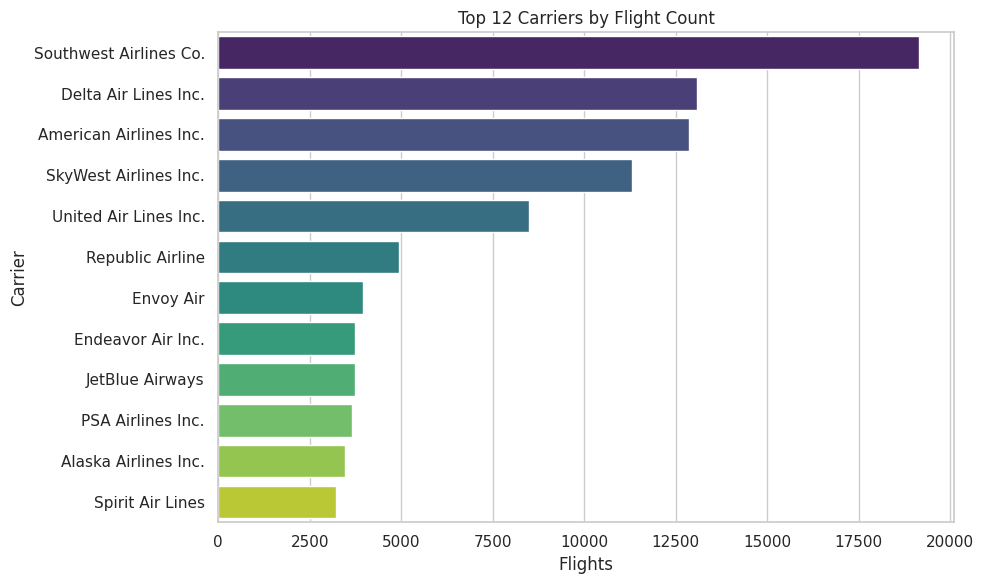

In [41]:
# Clean and preprocess carrier-level performance data
if 'carrier_stats' in locals():
    plt.figure(figsize=(10,6))
    top_carriers = carrier_stats.nlargest(12, 'flights')
    sns.barplot(data=top_carriers, x='flights', y='OP_CARRIER', palette='viridis')
    plt.title('Top 12 Carriers by Flight Count')
    plt.xlabel('Flights'); plt.ylabel('Carrier')
    plt.tight_layout()
    plt.show()
else:
    print("Cannot generate carrier plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and the previous cell ran successfully.")

In [42]:
# Merge carrier KPIs with additional operational metrics
if 'carrier_stats' in locals():
    fig = px.bar(carrier_stats.sort_values('cancel_rate', ascending=False).head(12), x='OP_CARRIER', y='cancel_rate',
                 title='Top 12 Carriers by Cancellation Rate (%)', labels={'cancel_rate':'Cancellation Rate (%)'})
    fig.show()
else:
    print("Cannot generate carrier plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

In [43]:
# Handle missing values or outliers in carrier metrics
delay_cols = [c for c in ['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY'] if c in df.columns]
if delay_cols:
    carrier_causes = df.groupby('OP_CARRIER')[delay_cols].mean().reset_index()
    carrier_causes_melt = carrier_causes.melt(id_vars='OP_CARRIER', var_name='cause', value_name='avg_minutes')
    plt.figure(figsize=(12,6))
    sns.barplot(data=carrier_causes_melt, x='OP_CARRIER', y='avg_minutes', hue='cause')
    plt.title('Avg Delay Minutes by Cause per Carrier')
    plt.xticks(rotation=45)
    plt.tight_layout()
else:
    print("No delay cause columns found.")


No delay cause columns found.


In [44]:
# Aggregate KPIs for visualization and summary
df['on_time'] = df['ARR_DELAY'] <= 15
on_time_stats = df.groupby('OP_CARRIER')['on_time'].mean().reset_index().rename(columns={'on_time':'on_time_rate'})
on_time_stats['on_time_rate'] = on_time_stats['on_time_rate']*100
on_time_stats.sort_values('on_time_rate', ascending=False).head(10)


,OP_CARRIER,on_time_rate
4,Endeavor Air Inc.,87.940235
3,Delta Air Lines Inc.,86.419281
9,Horizon Air,86.336336
8,Hawaiian Airlines Inc.,85.600000
14,SkyWest Airlines Inc.,85.237927
13,Republic Airline,84.641776
5,Envoy Air,83.880748
12,PSA Airlines Inc.,83.724741
0,Alaska Airlines Inc.,82.948644
17,United Air Lines Inc.,82.294851


In [45]:
#Compute airline KPIs
carrier_stats = (
    df.groupby("OP_CARRIER")
        .agg(
            flights=('OP_CARRIER','size'),
            avg_arr_delay=('ARR_DELAY','mean'),
            avg_dep_delay=('DEP_DELAY','mean'),
            cancelled=('CANCELLED','sum')
        )
        .reset_index()
)
carrier_stats['cancel_rate'] = carrier_stats['cancelled']/carrier_stats['flights']*100
carrier_stats.head()

,OP_CARRIER,flights,avg_arr_delay,avg_dep_delay,cancelled,cancel_rate
0,Alaska Airlines Inc.,3466,2.003751,5.153203,77,2.221581
1,Allegiant Air,1743,14.472175,15.605278,78,4.475043
2,American Airlines Inc.,12874,6.470638,12.425431,366,2.842939
3,Delta Air Lines Inc.,13070,1.239327,7.897858,195,1.491966
4,Endeavor Air Inc.,3748,-2.128602,4.677161,79,2.107791


/tmp/ipython-input-3424851615.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




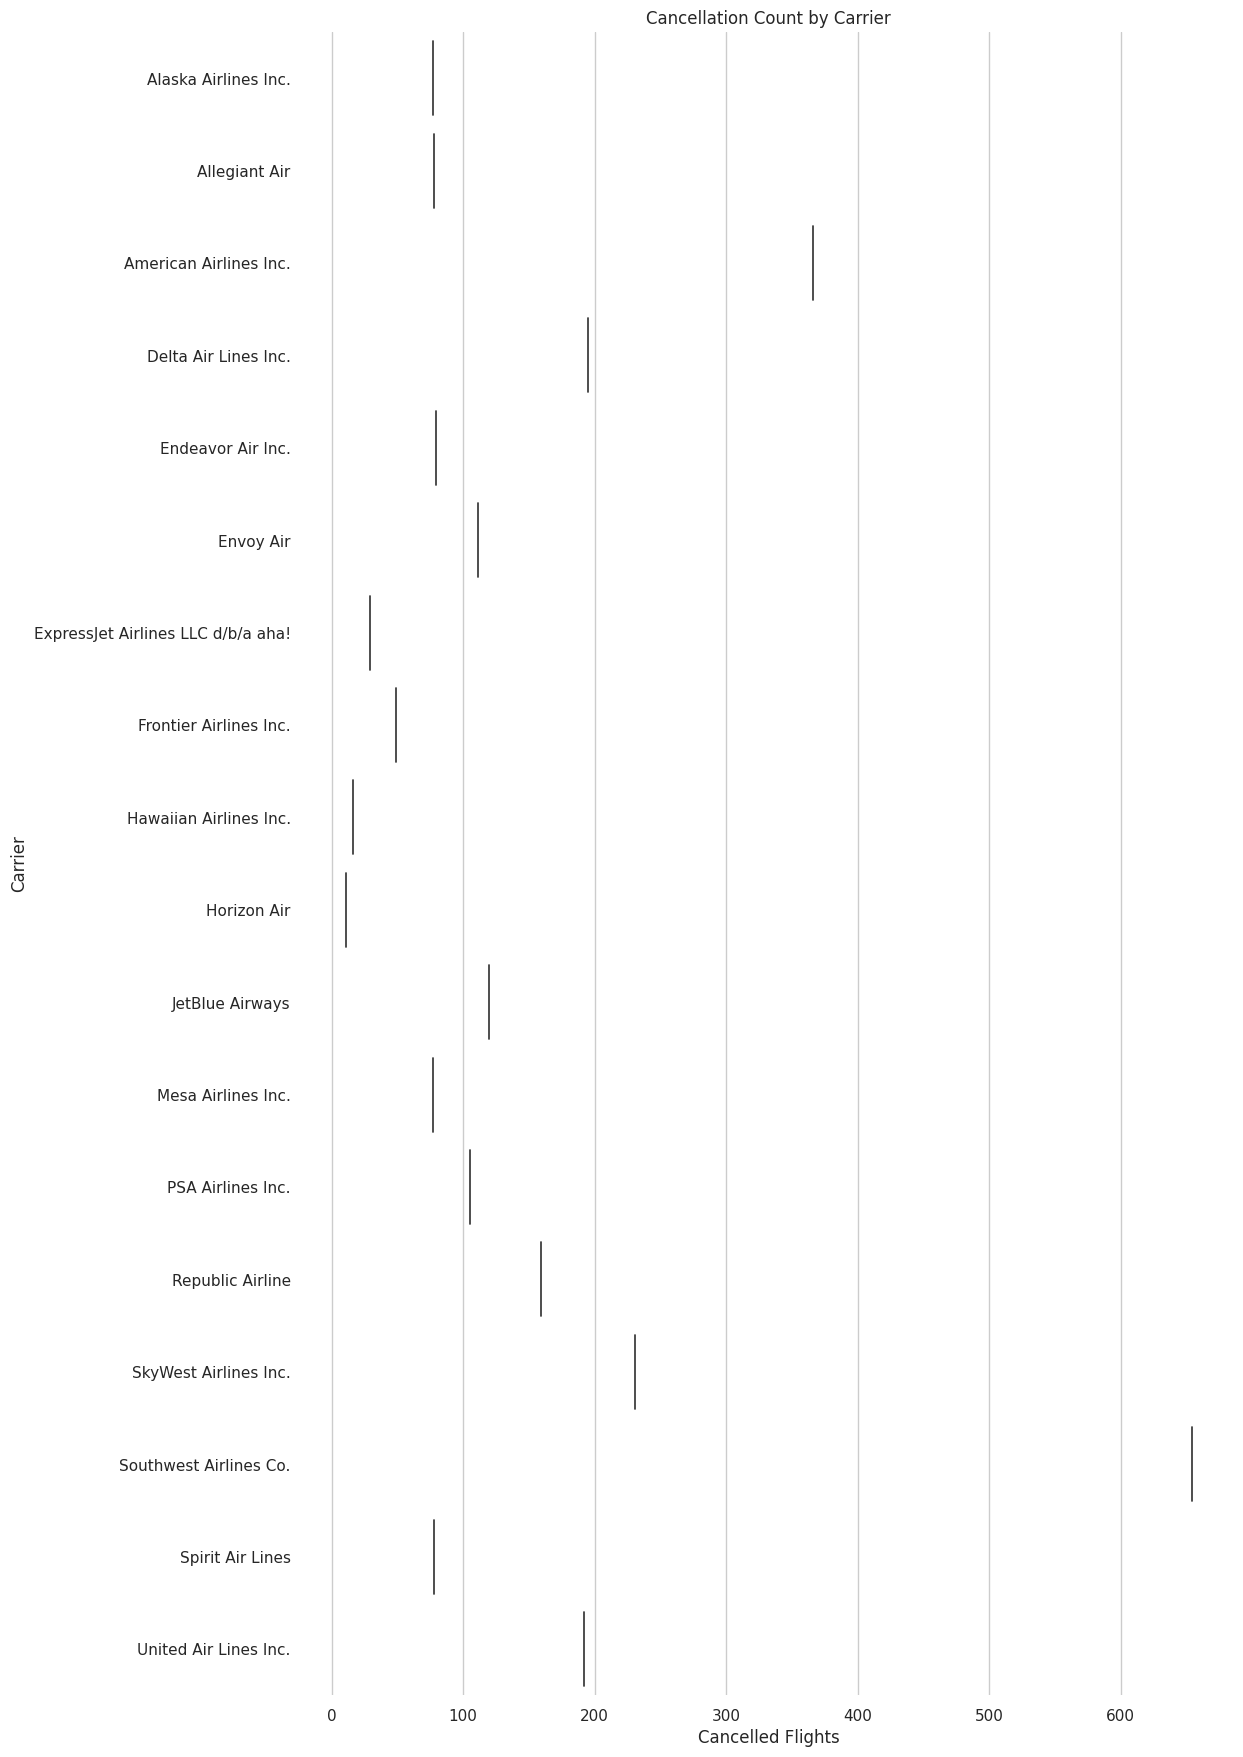

In [46]:
from matplotlib import pyplot as plt
import seaborn as sns

# Check if carrier_stats DataFrame exists
if 'carrier_stats' in locals():
    figsize = (12, 1.2 * len(carrier_stats['OP_CARRIER'].unique()))
    plt.figure(figsize=figsize)
    sns.violinplot(carrier_stats, x='cancelled', y='OP_CARRIER', inner='stick', palette='Dark2')
    sns.despine(top=True, right=True, bottom=True, left=True)
    plt.title('Cancellation Count by Carrier') # Added a title for clarity
    plt.xlabel('Cancelled Flights') # Added x-axis label
    plt.ylabel('Carrier') # Added y-axis label
    plt.show() # Ensure plot is displayed
else:
    print("Cannot generate carrier plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

/tmp/ipython-input-94126795.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




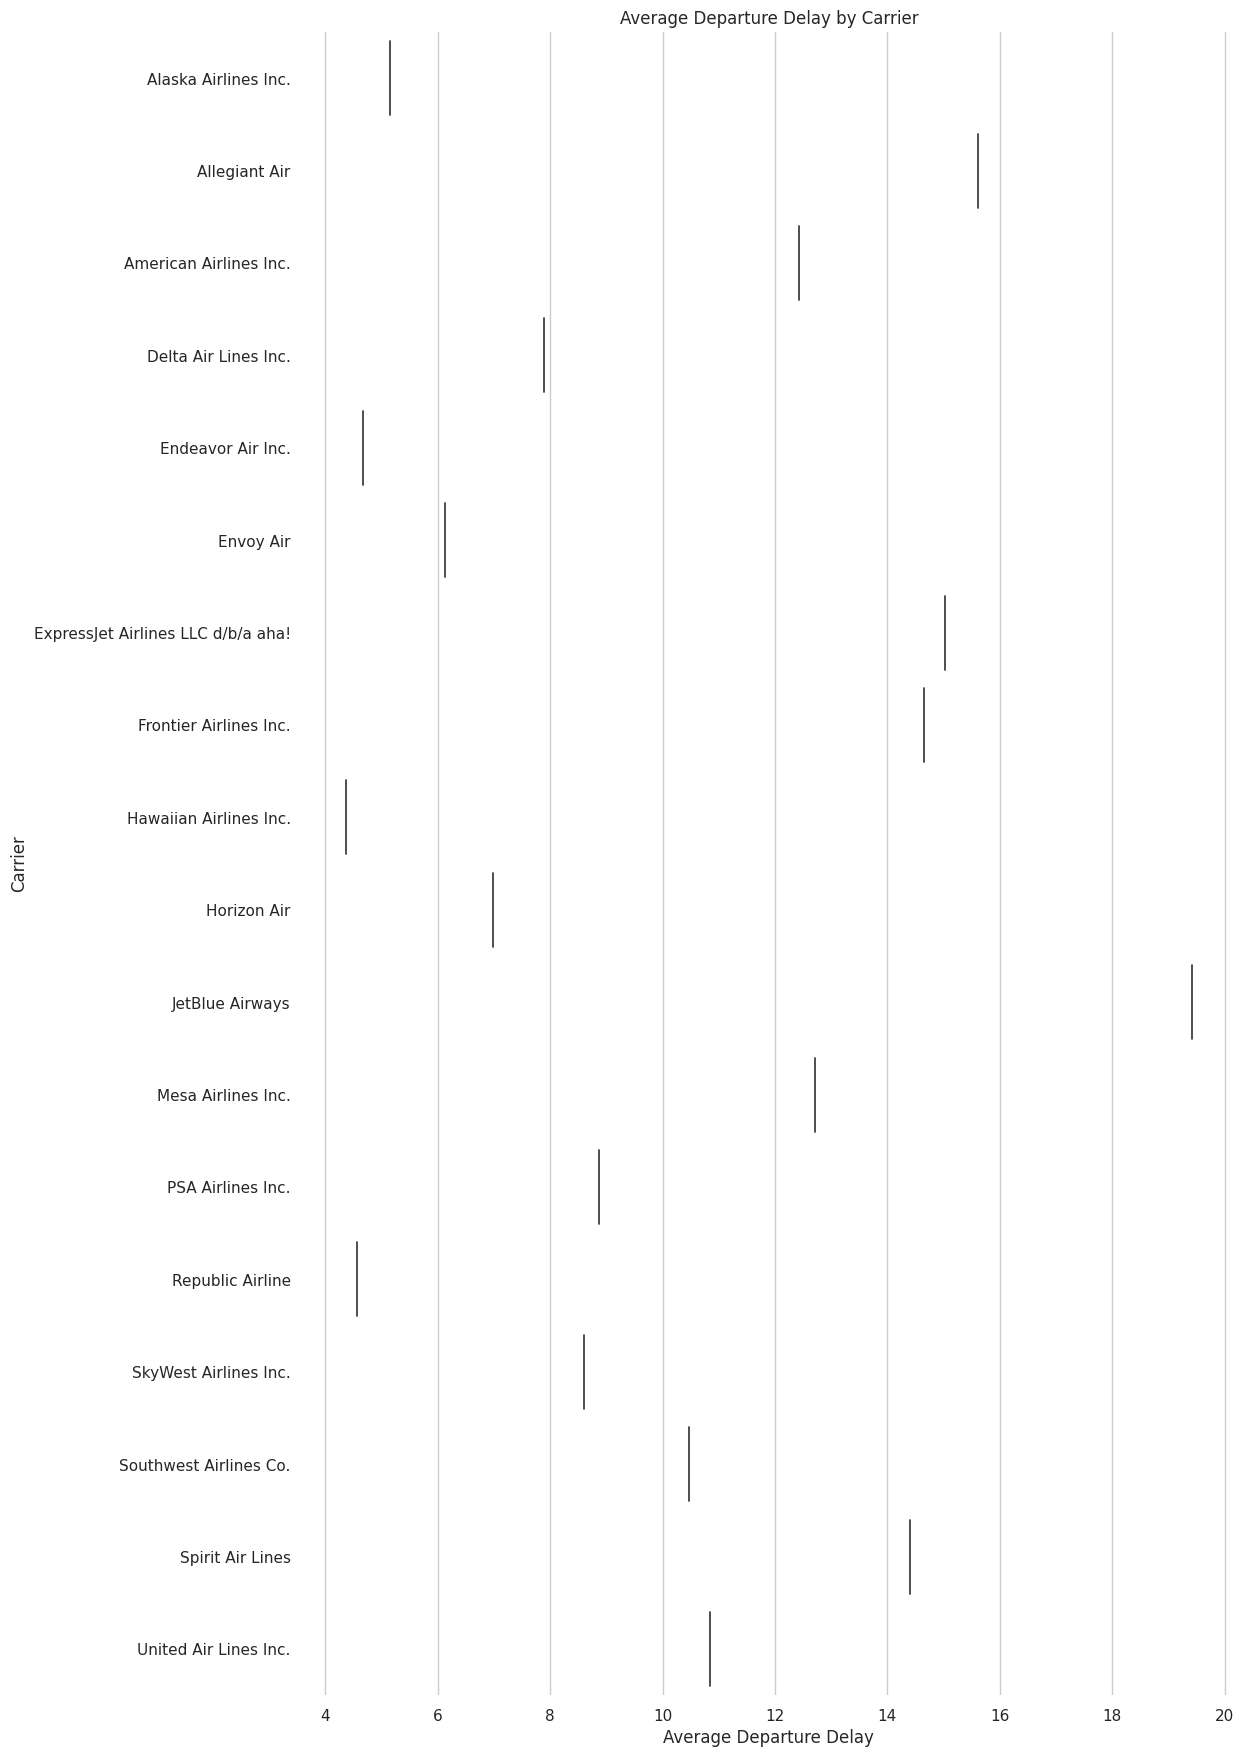

In [47]:
# Generate overall summary statistics across airlines
if 'carrier_stats' in locals():
    figsize = (12, 1.2 * len(carrier_stats['OP_CARRIER'].unique()))
    plt.figure(figsize=figsize)
    sns.violinplot(carrier_stats, x='avg_dep_delay', y='OP_CARRIER', inner='stick', palette='Dark2')
    sns.despine(top=True, right=True, bottom=True, left=True)
    plt.title('Average Departure Delay by Carrier') # Added a title for clarity
    plt.xlabel('Average Departure Delay') # Added x-axis label
    plt.ylabel('Carrier') # Added y-axis label
    plt.show() # Ensure plot is displayed
else:
    print("Cannot generate carrier plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

/tmp/ipython-input-104954915.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




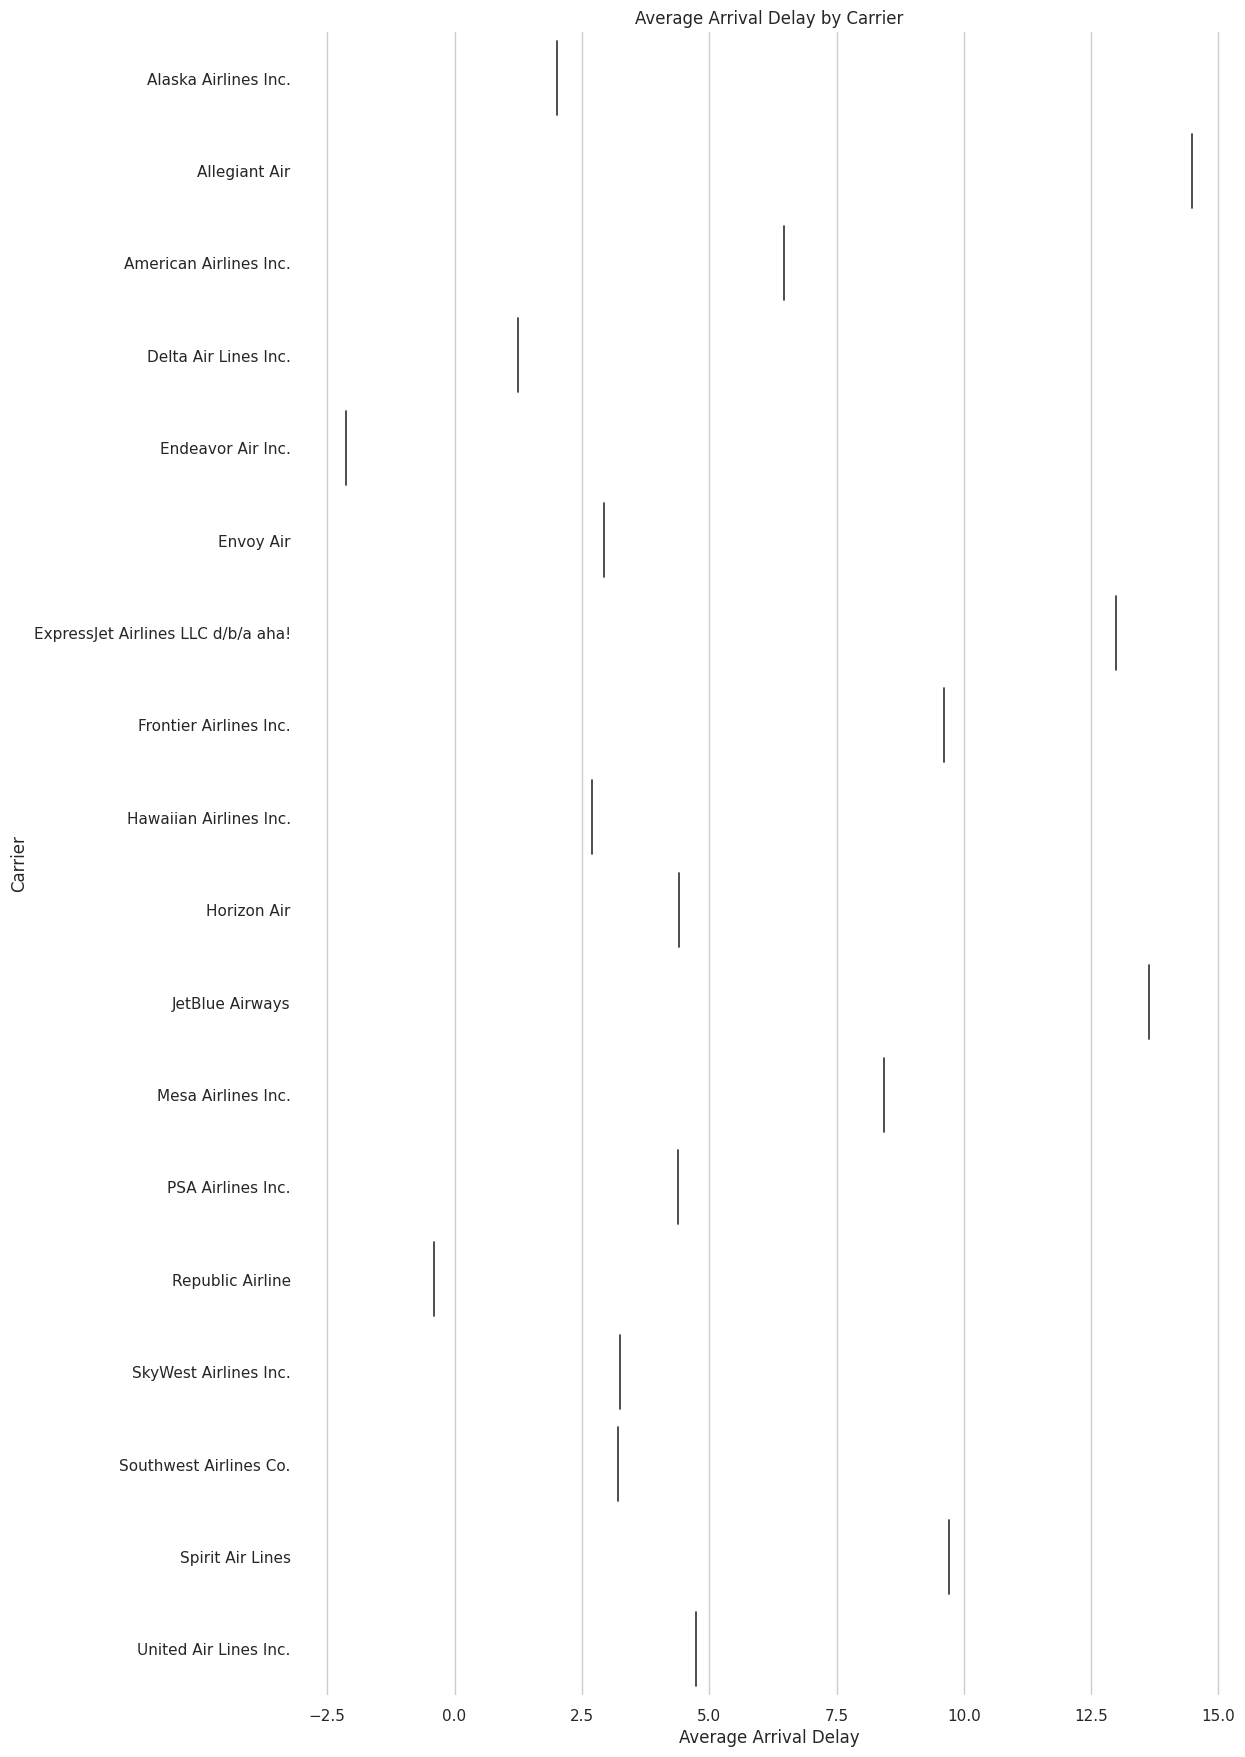

In [48]:
# Calculate average delay per airline and flight count
if 'carrier_stats' in locals():
    figsize = (12, 1.2 * len(carrier_stats['OP_CARRIER'].unique()))
    plt.figure(figsize=figsize)
    sns.violinplot(carrier_stats, x='avg_arr_delay', y='OP_CARRIER', inner='stick', palette='Dark2')
    sns.despine(top=True, right=True, bottom=True, left=True)
    plt.title('Average Arrival Delay by Carrier') # Added a title for clarity
    plt.xlabel('Average Arrival Delay') # Added x-axis label
    plt.ylabel('Carrier') # Added y-axis label
    plt.show() # Ensure plot is displayed
else:
    print("Cannot generate carrier plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

/tmp/ipython-input-1699435156.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




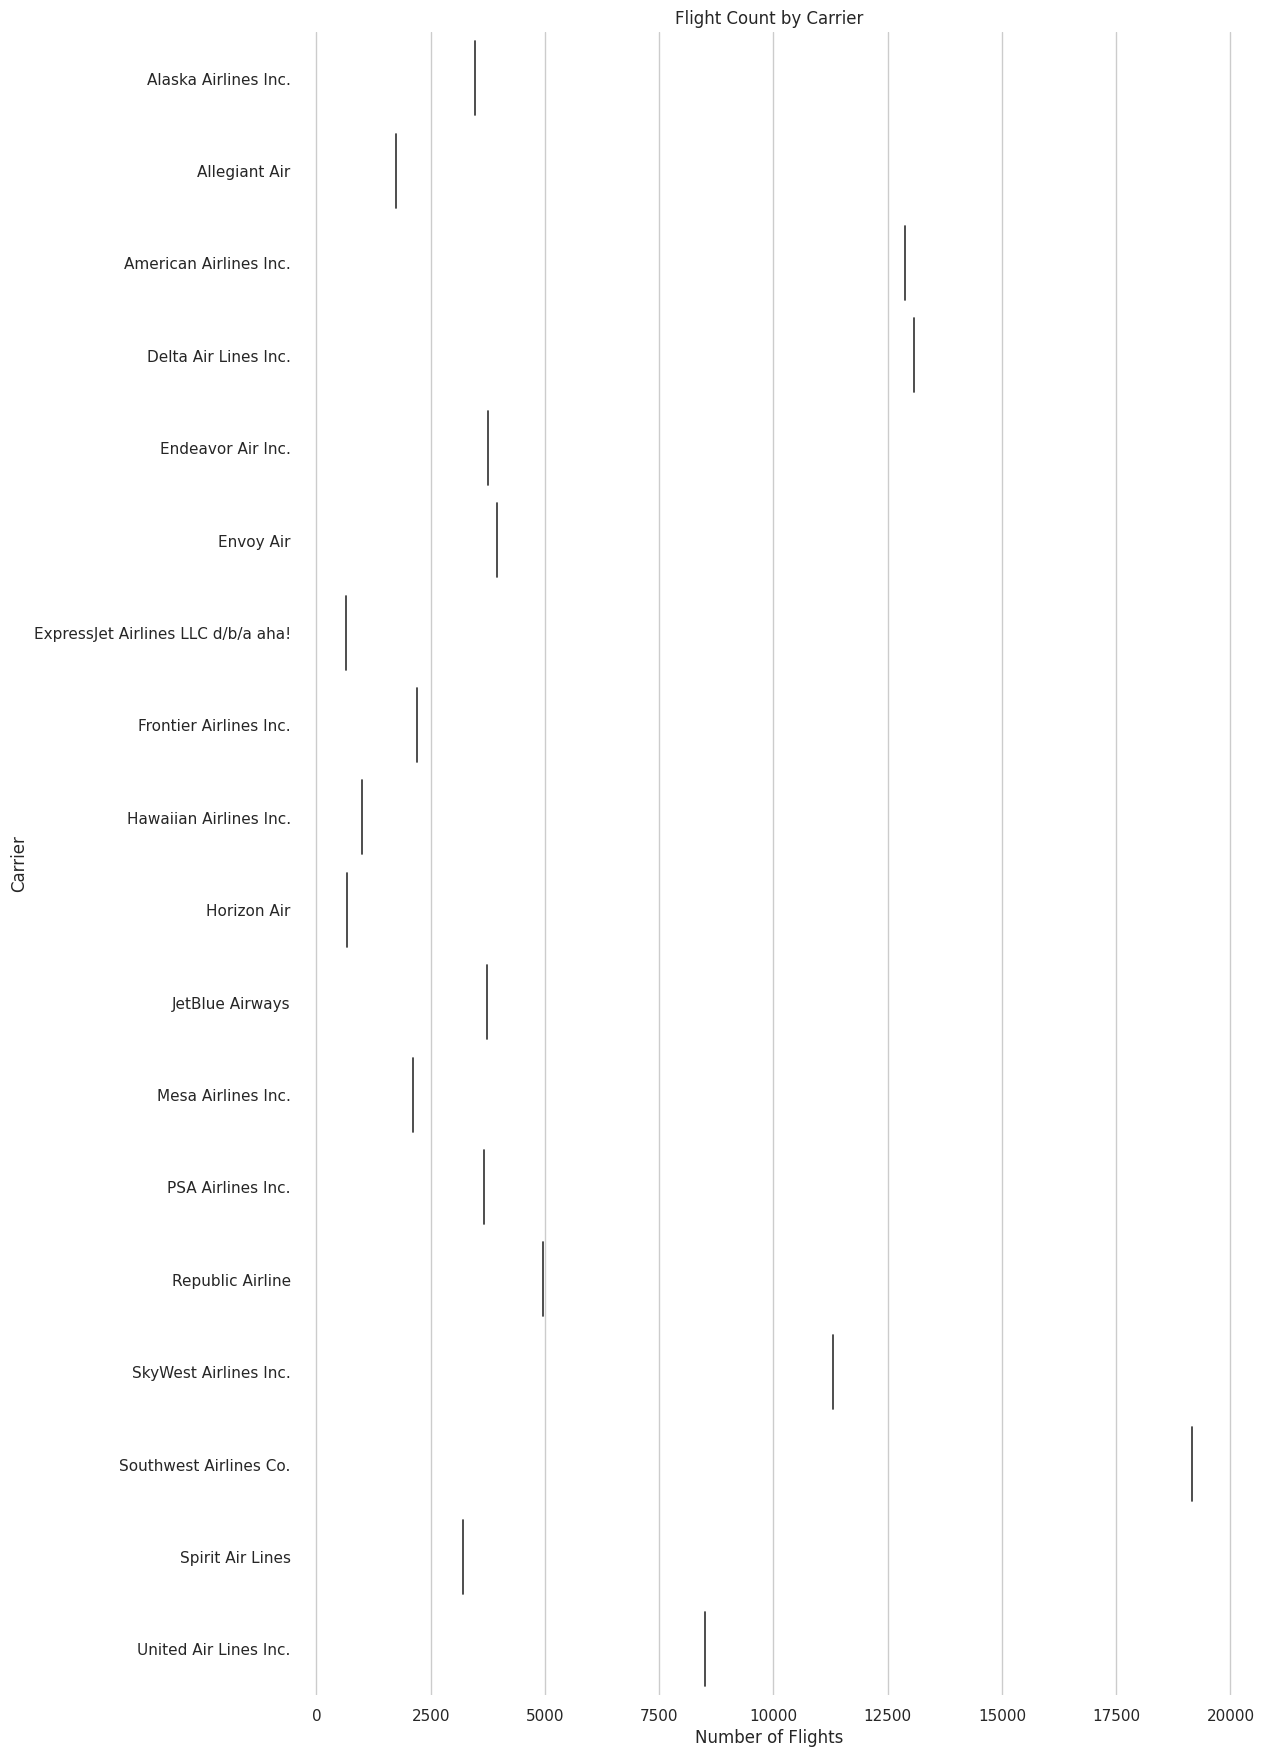

In [49]:
# Identify top and bottom performing carriers
if 'carrier_stats' in locals():
    figsize = (12, 1.2 * len(carrier_stats['OP_CARRIER'].unique()))
    plt.figure(figsize=figsize)
    sns.violinplot(carrier_stats, x='flights', y='OP_CARRIER', inner='stick', palette='Dark2')
    sns.despine(top=True, right=True, bottom=True, left=True)
    plt.title('Flight Count by Carrier') # Added a title for clarity
    plt.xlabel('Number of Flights') # Added x-axis label
    plt.ylabel('Carrier') # Added y-axis label
    plt.show() # Ensure plot is displayed
else:
    print("Cannot generate carrier plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

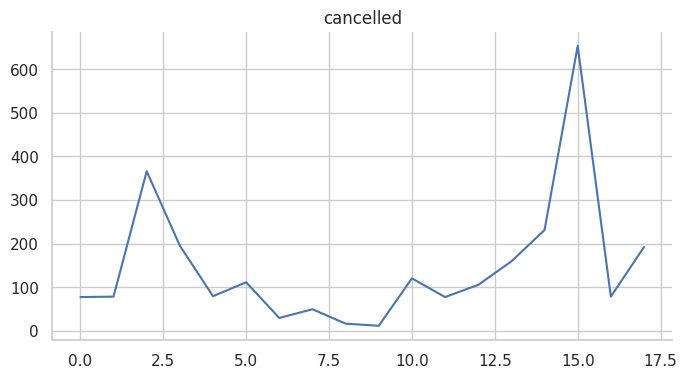

In [50]:
# Correlation analysis among carrier KPIs
if 'carrier_stats' in locals():
    carrier_stats['cancelled'].plot(kind='line', figsize=(8, 4), title='cancelled')
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()
else:
    print("Cannot generate plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

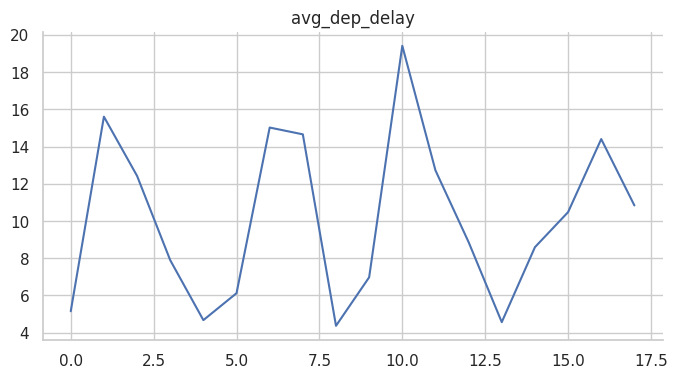

In [51]:
# Create visualization-ready dataframe for KPI trends
if 'carrier_stats' in locals():
    carrier_stats['avg_dep_delay'].plot(kind='line', figsize=(8, 4), title='avg_dep_delay')
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()
else:
    print("Cannot generate plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

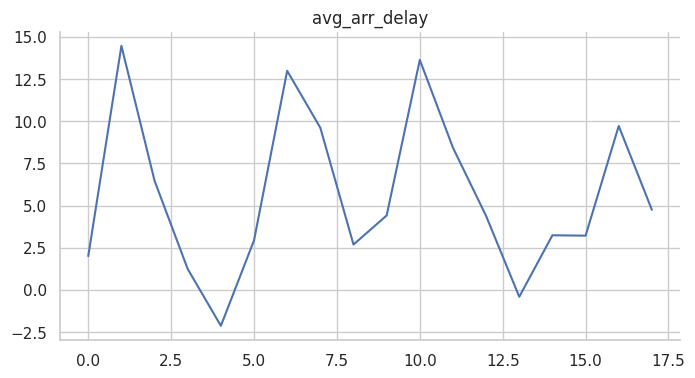

In [52]:
# Plot KPI comparison between top and low performing carriers
if 'carrier_stats' in locals():
    carrier_stats['avg_arr_delay'].plot(kind='line', figsize=(8, 4), title='avg_arr_delay')
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()
else:
    print("Cannot generate plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

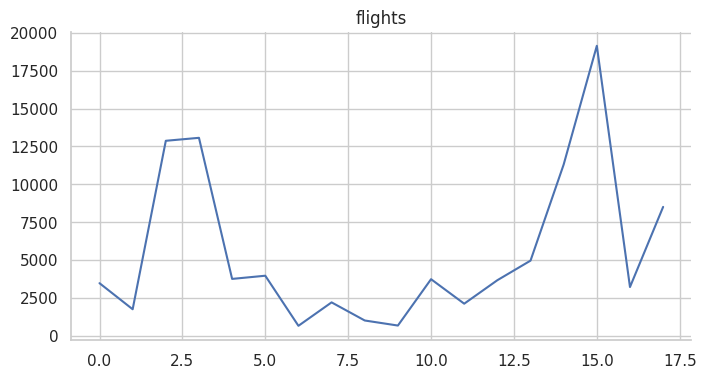

In [53]:
# Generate trendlines for average delay over time
if 'carrier_stats' in locals():
    carrier_stats['flights'].plot(kind='line', figsize=(8, 4), title='flights')
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()
else:
    print("Cannot generate plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

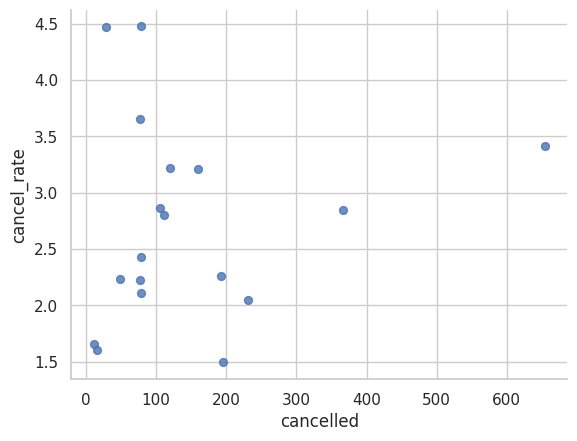

In [54]:
# Compute delay statistics grouped by month and carrier
if 'carrier_stats' in locals():
    carrier_stats.plot(kind='scatter', x='cancelled', y='cancel_rate', s=32, alpha=.8)
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.show()
else:
    print("Cannot generate plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

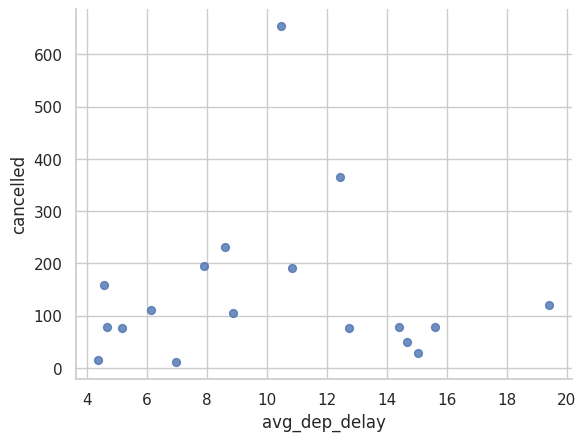

In [55]:
# Visualize flight volume and average delay over time
if 'carrier_stats' in locals():
    carrier_stats.plot(kind='scatter', x='avg_dep_delay', y='cancelled', s=32, alpha=.8)
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.show()
else:
    print("Cannot generate plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

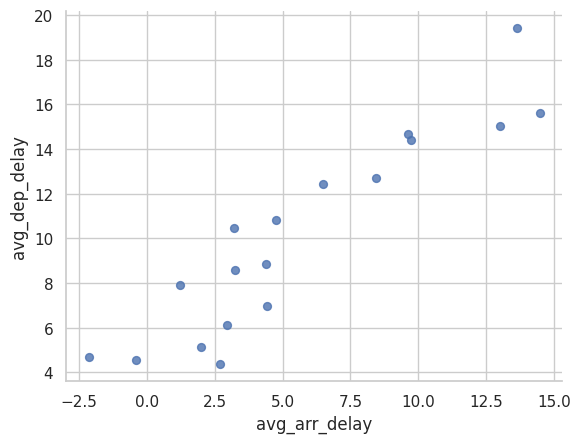

In [56]:
# Plot rolling average delays for carrier performance tracking
if 'carrier_stats' in locals():
    carrier_stats.plot(kind='scatter', x='avg_arr_delay', y='avg_dep_delay', s=32, alpha=.8)
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.show()
else:
    print("Cannot generate plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

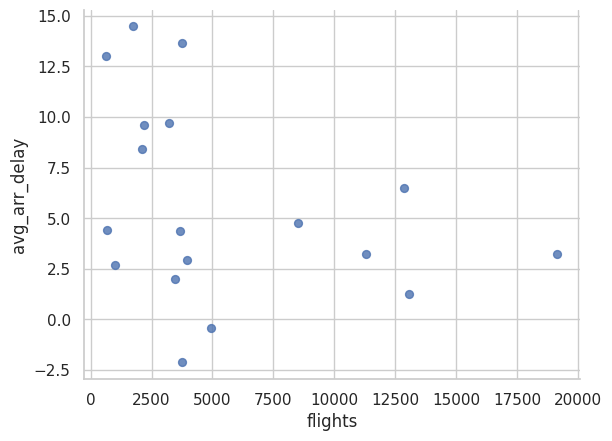

In [57]:
# Identify seasonal trends in delays using line charts
if 'carrier_stats' in locals():
    carrier_stats.plot(kind='scatter', x='flights', y='avg_arr_delay', s=32, alpha=.8)
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.show()
else:
    print("Cannot generate plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

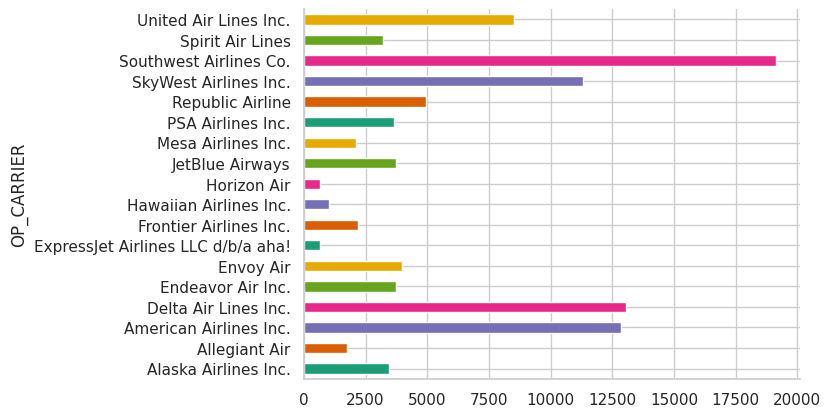

In [58]:
# Visualize cancellation rates over time
if 'carrier_stats' in locals():
    carrier_stats.groupby('OP_CARRIER')['flights'].sum().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.show() # Add plt.show() to display the plot
else:
    print("Cannot generate carrier plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

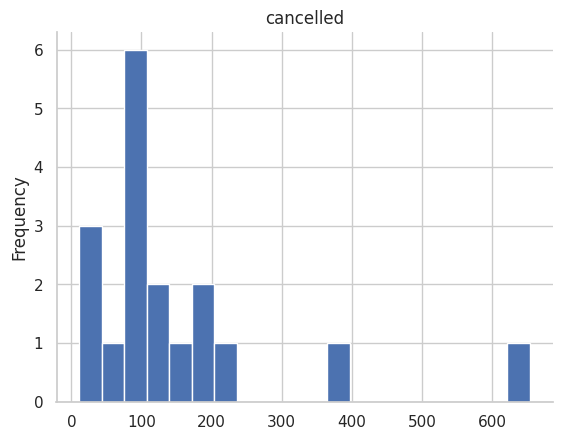

In [59]:
# Combine all metrics into a single summary dashboard dataframe
if 'carrier_stats' in locals():
    carrier_stats['cancelled'].plot(kind='hist', bins=20, title='cancelled')
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.show()
else:
    print("Cannot generate plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

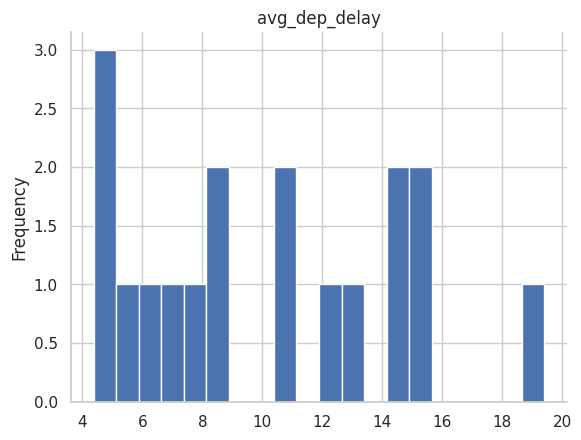

In [60]:
# Generate composite performance index for ranking airlines
if 'carrier_stats' in locals():
    carrier_stats['avg_dep_delay'].plot(kind='hist', bins=20, title='avg_dep_delay')
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.show()
else:
    print("Cannot generate plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

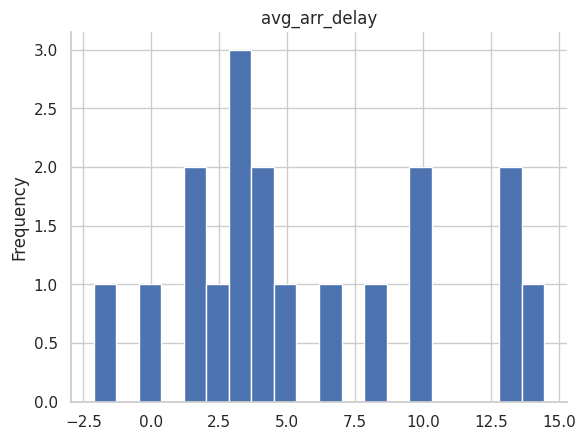

In [61]:
# Export computed metrics to CSV or display summary table
if 'carrier_stats' in locals():
    carrier_stats['avg_arr_delay'].plot(kind='hist', bins=20, title='avg_arr_delay')
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.show()
else:
    print("Cannot generate plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

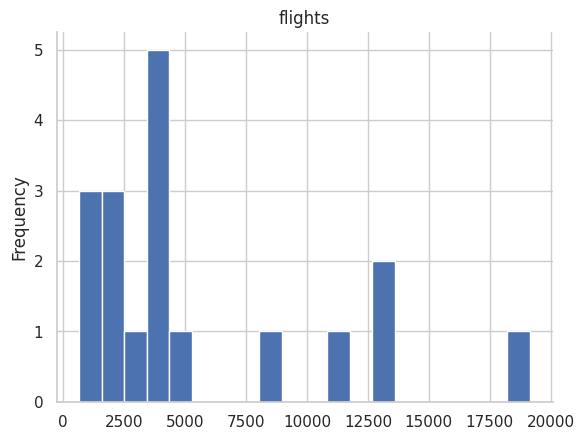

In [62]:
# Visualize correlations among KPIs with a heatmap
if 'carrier_stats' in locals():
    carrier_stats['flights'].plot(kind='hist', bins=20, title='flights')
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.show()
else:
    print("Cannot generate plot: 'carrier_stats' not found. Please ensure the 'OP_CARRIER' column is in your data and cell 15joWMT07Gll ran successfully.")

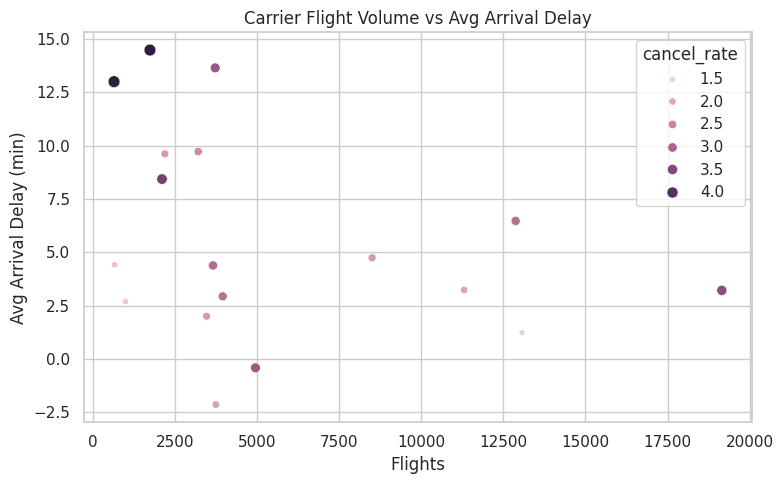

In [63]:
#Flights vs Average Delay scatter
plt.figure(figsize=(8,5))
sns.scatterplot(data=carrier_stats, x='flights', y='avg_arr_delay', hue='cancel_rate', size='cancel_rate')
plt.title('Carrier Flight Volume vs Avg Arrival Delay')
plt.xlabel('Flights'); plt.ylabel('Avg Arrival Delay (min)')
plt.tight_layout()


/tmp/ipython-input-2552703048.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




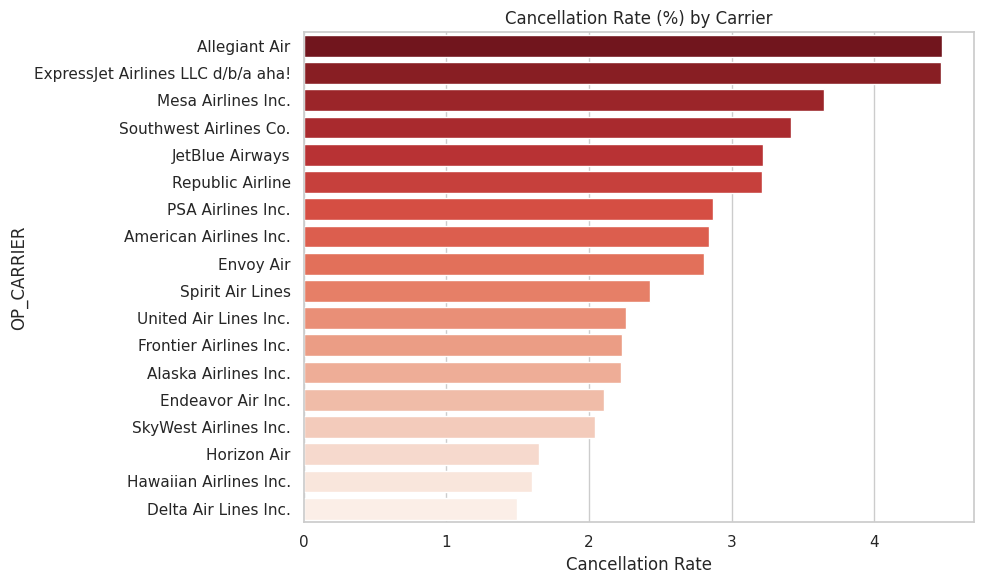

In [64]:
#Barplot: cancellation rate by carrier
plt.figure(figsize=(10,6))
sns.barplot(data=carrier_stats.sort_values('cancel_rate',ascending=False),
            x='cancel_rate', y='OP_CARRIER', palette='Reds_r')
plt.title('Cancellation Rate (%) by Carrier')
plt.xlabel('Cancellation Rate');
plt.tight_layout()


Text(0.5, 1.0, 'Monthly Average Arrival Delay by Carrier')

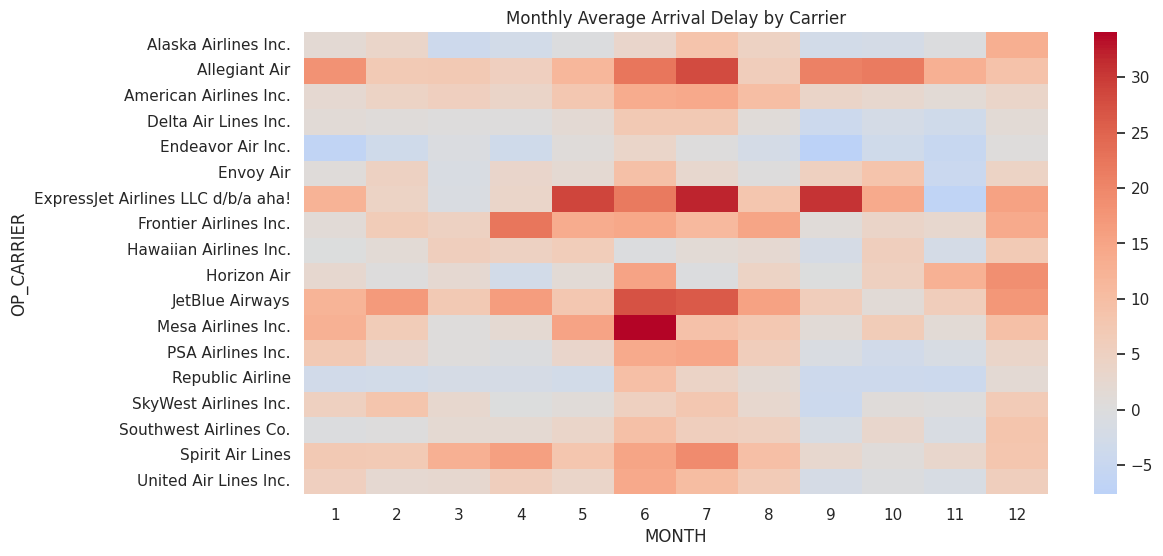

In [65]:
#Heatmap: Monthly delay by carrier
df['MONTH'] = pd.to_datetime(df['FL_DATE']).dt.month
pivot = df.pivot_table(index='OP_CARRIER', columns='MONTH', values='ARR_DELAY', aggfunc='mean')
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='coolwarm', center=0)
plt.title('Monthly Average Arrival Delay by Carrier')

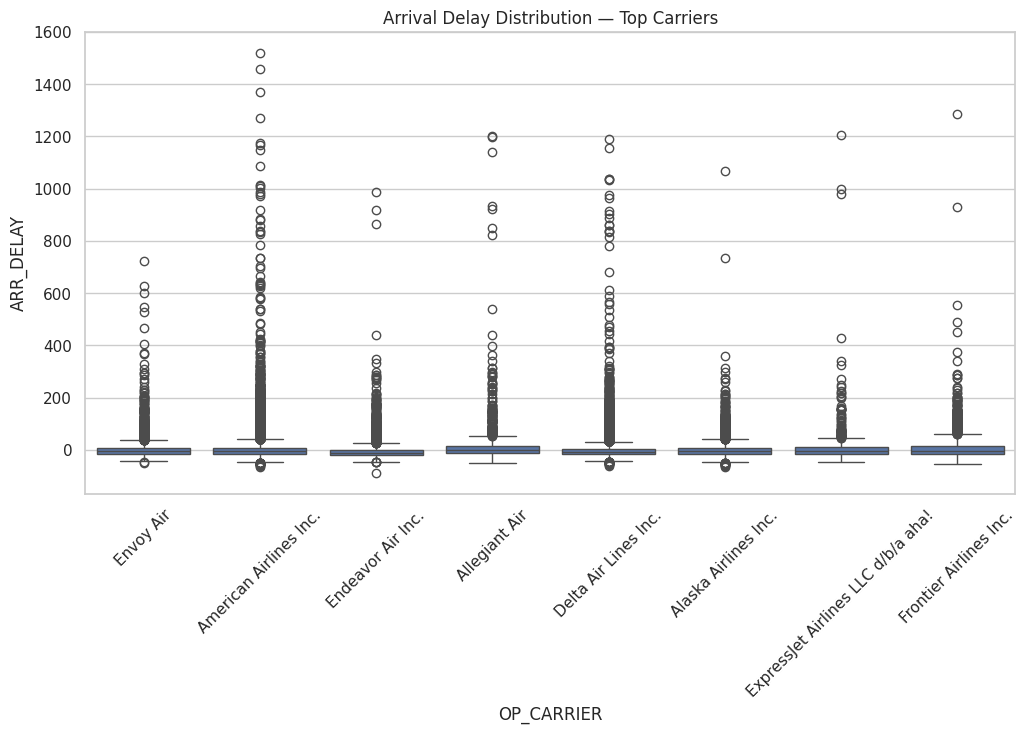

In [66]:
#Boxplot: Arrival delay distribution across carriers
plt.figure(figsize=(12,6))
sns.boxplot(data=df[df['OP_CARRIER'].isin(carrier_stats.OP_CARRIER.head(8))],
            x='OP_CARRIER', y='ARR_DELAY')
plt.title('Arrival Delay Distribution — Top Carriers')
plt.xticks(rotation=45)
plt.show()

,OP_CARRIER,MONTH,ARR_DELAY
0,Alaska Airlines Inc.,1,1.767213
1,Alaska Airlines Inc.,2,3.500000
2,Alaska Airlines Inc.,3,-3.878049
3,Alaska Airlines Inc.,4,-2.587591
4,Alaska Airlines Inc.,5,-0.432990


Number of unique carriers in monthly data: 18


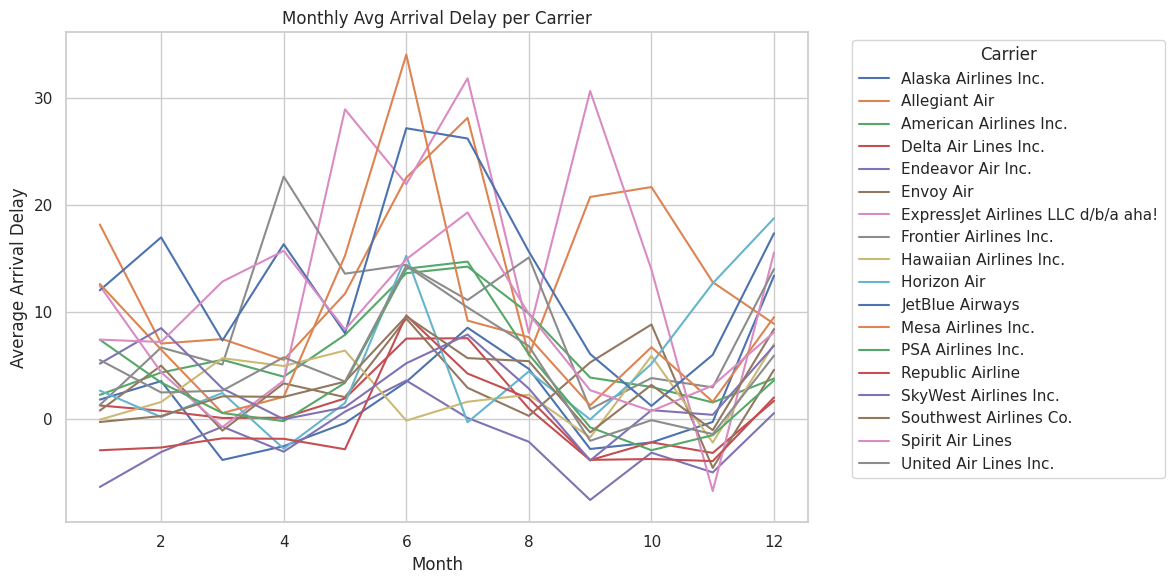

In [67]:
#Animated monthly delay trend
monthly = df.groupby(['OP_CARRIER','MONTH'])['ARR_DELAY'].mean().reset_index()
display(monthly.head()) # Display the dataframe before plotting

# Check the number of unique carriers
num_carriers = monthly['OP_CARRIER'].nunique()
print(f"Number of unique carriers in monthly data: {num_carriers}")

if num_carriers > 1:
    # Use matplotlib for a static plot
    plt.figure(figsize=(12, 6))
    for carrier in monthly['OP_CARRIER'].unique():
        carrier_data = monthly[monthly['OP_CARRIER'] == carrier]
        plt.plot(carrier_data['MONTH'], carrier_data['ARR_DELAY'], label=carrier)

    plt.title('Monthly Avg Arrival Delay per Carrier')
    plt.xlabel('Month')
    plt.ylabel('Average Arrival Delay')
    plt.legend(title='Carrier', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Less than 2 unique carriers found. Plotting with color might not be meaningful.")

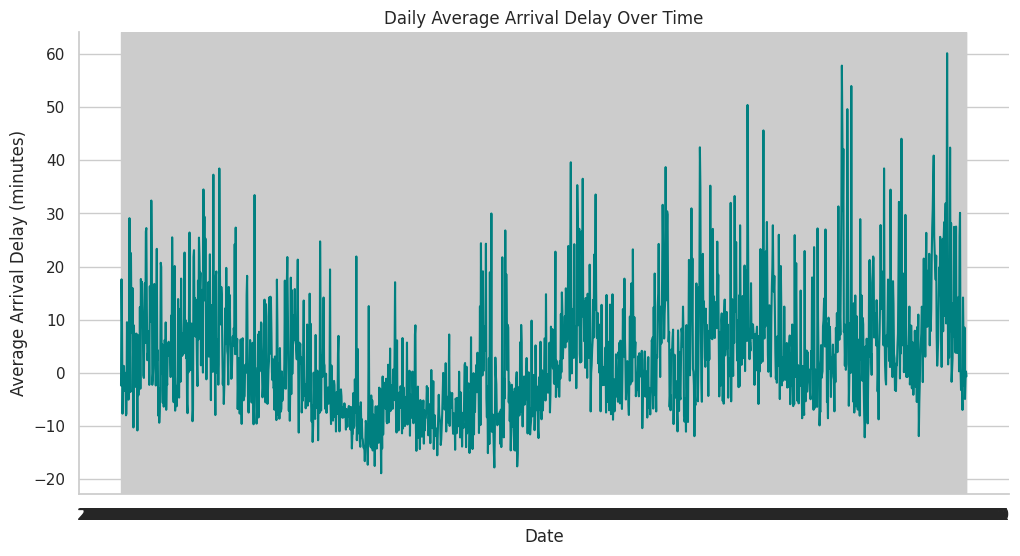

In [68]:
if 'df' in locals():
    # Calculate daily average arrival delay
    daily_avg_delay = df.groupby('FL_DATE')['ARR_DELAY'].mean().reset_index()

    # Plot daily average arrival delay
    plt.figure(figsize=(12, 6))
    plt.plot(daily_avg_delay['FL_DATE'], daily_avg_delay['ARR_DELAY'], color='teal')
    plt.title('Daily Average Arrival Delay Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average Arrival Delay (minutes)')
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()
else:
    print("Cannot generate plot: 'df' not found. Please ensure the DataFrame is loaded successfully.")

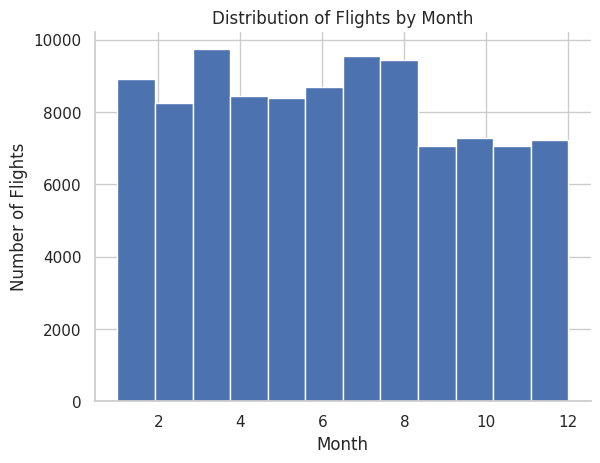

In [69]:
if 'df' in locals():
    # Plot a histogram of the 'MONTH' column to show distribution of flights per month
    df['MONTH'].plot(kind='hist', bins=12, title='Distribution of Flights by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Flights')
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()
else:
    print("Cannot generate plot: 'df' not found. Please ensure the DataFrame is loaded successfully.")

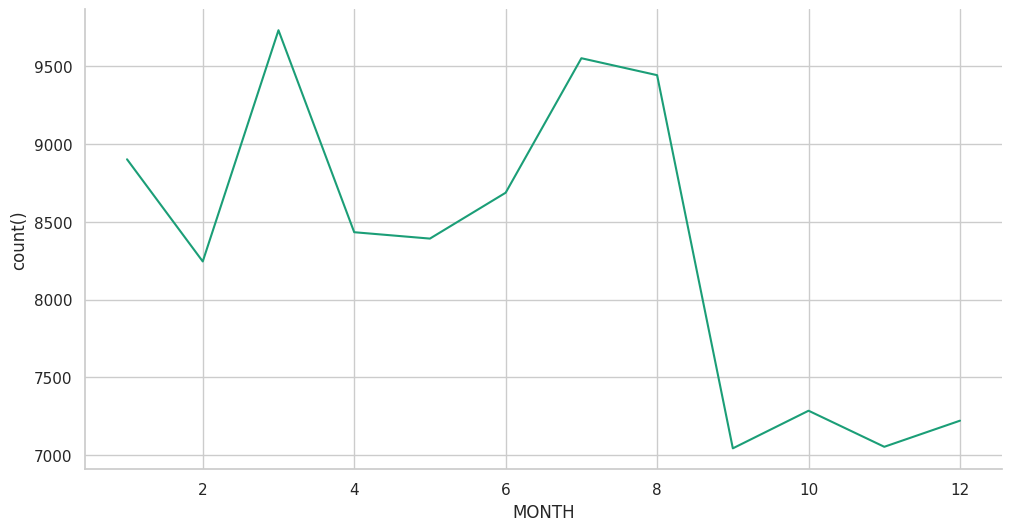

In [70]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['MONTH']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'MONTH'}, axis=1)
              .sort_values('MONTH', ascending=True))
  xs = counted['MONTH']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
# Use the existing 'df' DataFrame instead of the undefined '_df_21'
if 'df' in locals():
    df_sorted = df.sort_values('MONTH', ascending=True)
    _plot_series(df_sorted, '')
    sns.despine(fig=fig, ax=ax)
    plt.xlabel('MONTH')
    _ = plt.ylabel('count()')
    plt.show()
else:
    print("Cannot generate plot: 'df' not found. Please ensure the DataFrame is loaded successfully.")

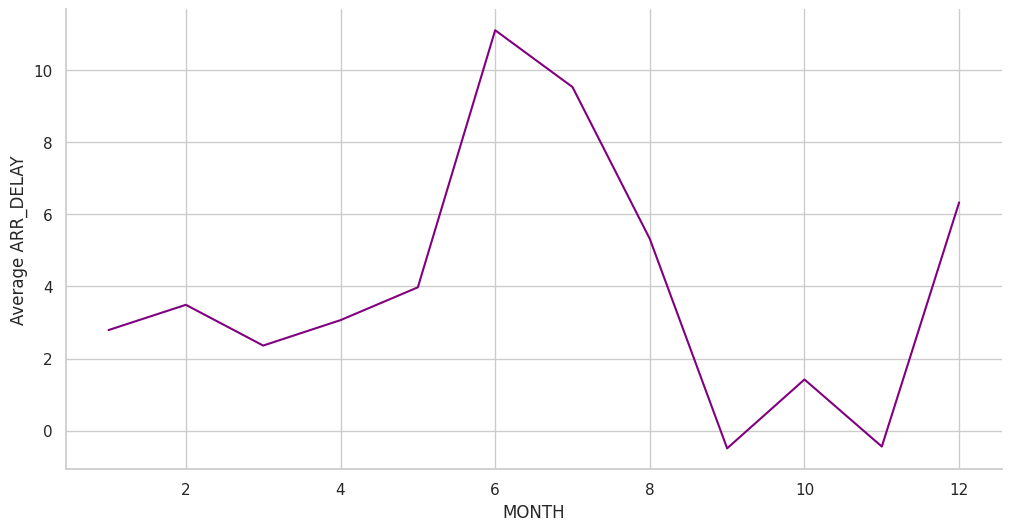

In [71]:
# Calculate average arrival delay per month
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series.index
  ys = series.values

  # Changed the color to 'purple'
  plt.plot(xs, ys, label=series_name, color='purple')

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
if 'df' in locals():
    # Calculate average arrival delay per month using the correct DataFrame 'df'
    monthly_avg_delay = df.groupby('MONTH')['ARR_DELAY'].mean()
    _plot_series(monthly_avg_delay, '')
    sns.despine(fig=fig, ax=ax)
    plt.xlabel('MONTH')
    _ = plt.ylabel('Average ARR_DELAY')
    plt.show() # Add plt.show() to display the plot
else:
    print("Cannot generate plot: 'df' not found. Please ensure the DataFrame is loaded successfully.")

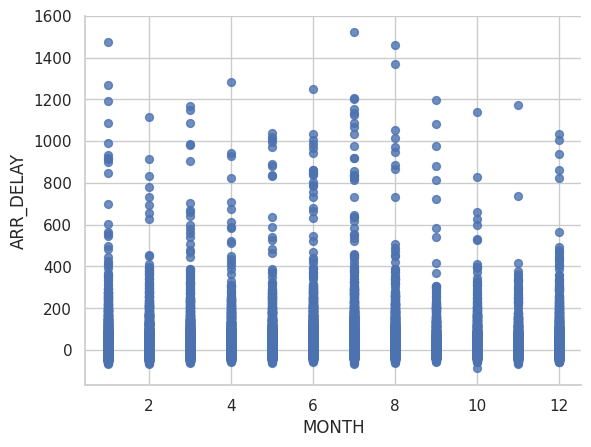

In [72]:
# Generate dashboard layout combining all visualizations
if 'df' in locals():
    df.plot(kind='scatter', x='MONTH', y='ARR_DELAY', s=32, alpha=.8)
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.show() # Add plt.show() to display the plot
else:
    print("Cannot generate plot: 'df' not found. Please ensure the DataFrame is loaded successfully.")

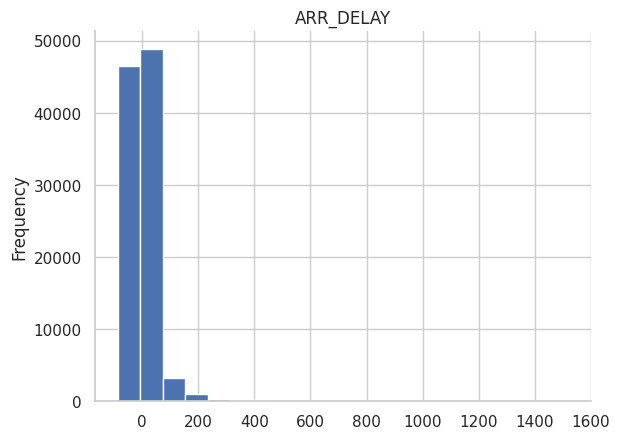

In [73]:
# Apply consistent styling and formatting to charts
if 'df' in locals():
    df['ARR_DELAY'].plot(kind='hist', bins=20, title='ARR_DELAY')
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.show() # Add plt.show() to display the plot
else:
    print("Cannot generate plot: 'df' not found. Please ensure the DataFrame is loaded successfully.")

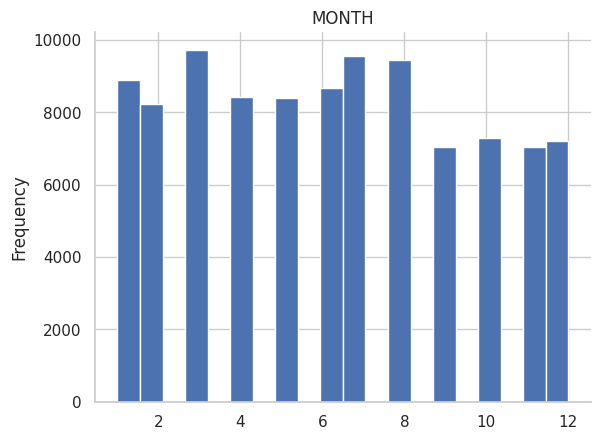

In [74]:
# Summarize insights and observations from week 6 analysis
if 'df' in locals():
    df['MONTH'].plot(kind='hist', bins=20, title='MONTH')
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.show() # Add plt.show() to display the plot
else:
    print("Cannot generate plot: 'df' not found. Please ensure the DataFrame is loaded successfully.")

Text(0.5, 1.0, 'On-Time Performance by Carrier (%)')

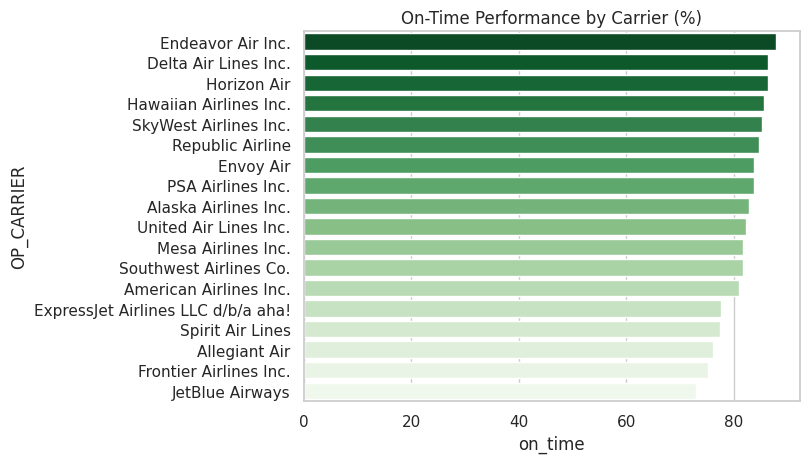

In [75]:
#On-time performance ranking
df['on_time'] = (df['ARR_DELAY']<=15)
on_time = df.groupby('OP_CARRIER')['on_time'].mean().reset_index()
on_time['on_time']*=100
sns.barplot(data=on_time.sort_values('on_time',ascending=False), x='on_time', y='OP_CARRIER', hue='OP_CARRIER', palette='Greens_r', legend=False)
plt.title('On-Time Performance by Carrier (%)')

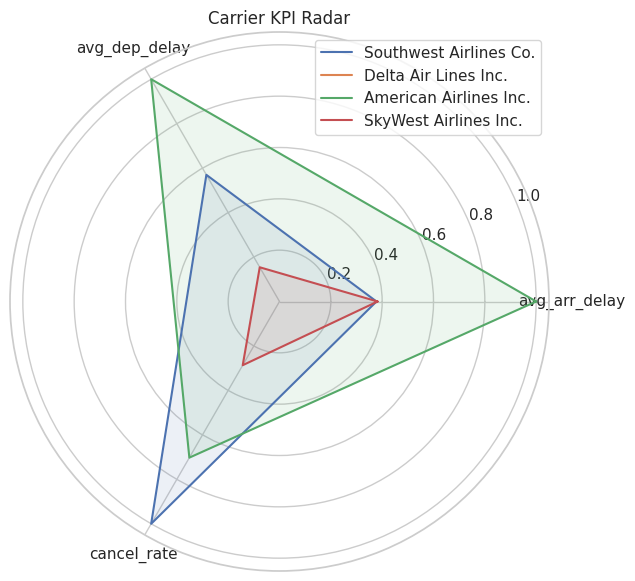

In [76]:
#Radar chart: normalized KPIs
from math import pi
top4 = carrier_stats.nlargest(4,'flights').set_index('OP_CARRIER')
metrics = ['avg_arr_delay','avg_dep_delay','cancel_rate']
norm = (top4[metrics]-top4[metrics].min())/(top4[metrics].max()-top4[metrics].min())
angles = [n/len(metrics)*2*pi for n in range(len(metrics))]; angles += angles[:1]
plt.figure(figsize=(7,7)); ax=plt.subplot(111,polar=True)
for carrier,row in norm.iterrows():
    vals=row.tolist(); vals+=vals[:1]
    ax.plot(angles, vals, label=carrier); ax.fill(angles, vals, alpha=0.1)
ax.set_xticks(angles[:-1]); ax.set_xticklabels(metrics)
plt.title('Carrier KPI Radar');
plt.legend()